In [1]:
import sys
import os

root_dir = "./output/"
# local_drive_path = os.path.expanduser("~/Documents/MyProject")  
# sys.path.append(local_drive_path)



In [2]:
from parameters import *
from market_models import Factor
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# 禁用 UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)   

cuda


# Networks

In [4]:
class InnerNet(nn.Module):
    
    def __init__(self, n_hidden):
        super(InnerNet, self).__init__()
        self.fc_inp_h1 = nn.Linear(1, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.fc_h2_out(x)      
      
        return y

class OuterNet(nn.Module):
    def __init__(self, n_assets):
        super(OuterNet, self).__init__()
        self.fc_inp_out = nn.Linear(1, n_assets)
        self.mySoftmax = nn.Softmax()

    def forward(self, x):
        y = self.mySoftmax(self.fc_inp_out(x))         
        return y

# Agents

In [5]:
class Robust_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update = True):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)
    _, _, Nsims, Nassets, _, _, _ = self.sim_params.GetParams()
    self.weights_history = np.empty((Nassets, 0))
    self.X_phi_history = np.empty((Nsims, 0))

  def sim_phi(self):
    # Nsims by Nassets tensor of asset returns
    S = np.squeeze(self.market_model.S, axis = 0)
    returns_tensor = torch.FloatTensor(S).to(self.device)
    # find asset weights of phi strategy and calculate total returns
    zero_tensor = torch.zeros(1).to(self.device)
    weights = self.outer_net(zero_tensor).reshape(-1, 1)
    # $X^\phi = phi^T X$
    X_phi = torch.matmul(returns_tensor, weights)
    self.weights_history = np.concatenate((self.weights_history, weights.cpu().detach().numpy()), axis = 1)
    self.X_phi_history = np.concatenate((self.X_phi_history, X_phi.cpu().detach().numpy()), axis = 1)
    return X_phi
  
  def PlotCustom(self, X, Y, adversary):
    print("### Outer Problem Metrics ###")
    self.PrintWeights()
    if self.weights_history.shape[1] > 1:
      self.PlotStrategy()
    if self.X_phi_history.shape[1] > 1:
      self.PlotHistory()
    print("### Inner Problem Metrics ###")
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)
    
  def PrintWeights(self):
    print("Weights: ", self.weights_history[:, -1])
    _, _, _, _, _, _, _, freeze_inner_iter = self.train_params.GetParams()
    lookback = min(freeze_inner_iter, self.weights_history.shape[1] - 1)
    # asset weight difference from the current phi strategy and phi strategy freeze_inner_iter training iterations before
    print("Weights Delta: ", self.weights_history[:, -1] - self.weights_history[:, -1 - lookback])


  def PlotStrategy(self):
    # plot stacked asset weights over training iterations
    iter = range(self.weights_history.shape[1])
    Nassets = self.weights_history.shape[0]
    labels = ["Asset {}".format(i) for i in range(Nassets)]
    
    plt.stackplot(iter, self.weights_history, labels = labels, colors = ['darkblue', 'blue', 'deepskyblue', 'cyan', 'springgreen', 'greenyellow', 'gold', 'orange', 'red', 'maroon'])
    plt.xlabel("Training Iteration", fontsize = 18)
    plt.ylabel(r"$\phi$ asset weights", fontsize = 18)
    plt.tight_layout()
    plt.show()


  

In [6]:
class Robust_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "maximize", reset_lm = True, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    X_theta_T = self.inner_net(X_phi_T)
    return X_theta_T
  
  def PlotCustom(self, X, Y):
    self.PlotDistortion(X,Y)

# Parameters

In [17]:
sim_param_dict = { "Nassets" : 10,
                   "Nsims" : 6000,
                }

train_param_dict = {"inner_epochs" : 500, #内层训练迭代500次
                    "outer_epochs" : 81, #外层训练迭代81次，共81×500=40500次
                    "plot_freq_inner": np.inf,#内层训练的绘图频率，无穷大表示在内层训练中不进行绘图。
                    "plot_freq_outer" : 40, #外层训练的绘图频率，表示每40次迭代画一次图
                    "inner_lr" : 1e-3, #内层学习率
                    "outer_lr" : 1e-2, #外层学习率
                    "freeze_market_iter" : 1, #市场参数冻结的迭代次数
                    "freeze_inner_iter" : 10 #内层模型参数将在10次迭代中保持不变
                   }

sim_params = Sim_Params(sim_param_dict)
train_params = Train_Params(train_param_dict)
factor_model = Factor()

# Results


## Alpha-Beta Risk Measure

$$
\gamma(u)=\frac{1}{\eta}(p\cdot \mathbf{1}_{\{u\leq\alpha\}}+(1-p)\cdot \mathbf{1}_{\{u>\alpha\}}),\\
\text{where}\quad \eta=p\alpha+(1-p)(1-\beta).
$$
$\alpha = 0.1, \beta = 0.9, p = 0.75$


In [18]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }
                  
rm_params = RM_Params(RM_param_dict)

### Wass 1e-3

In [19]:
LM_param_dict = { "lam": 1,
                  "mu": 2000,
                  "mu_update": 1.5,
                  "update_freq": 100 #1000
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-3
                  }
                  
lm_params_0 = LM_Params(LM_param_dict)
wass_params_0 = Wass_Params(wass_param_dict)

Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.23403355 0.07835846 0.21713755 0.04206697 0.08278804 0.08625354
 0.09075161 0.05210764 0.05503559 0.06146707]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.0021877556573599577, 0.0021864722948521376, 0.0021837642416357994, 0.0021825104486197233, 0.002183490199968219]
Risk Measure X_theta History:  [0.03896878659725189, 0.039131127297878265, 0.039066508412361145, 0.03905818238854408, 0.039148375391960144]
Loss History:  [-0.055549148470163345, -0.059601154178380966, -0.06317562609910965, -0.06244216486811638, -0.06546378880739212]
Augmented Lagrangian lambda: 77.39943719096482 mu: 15187.5


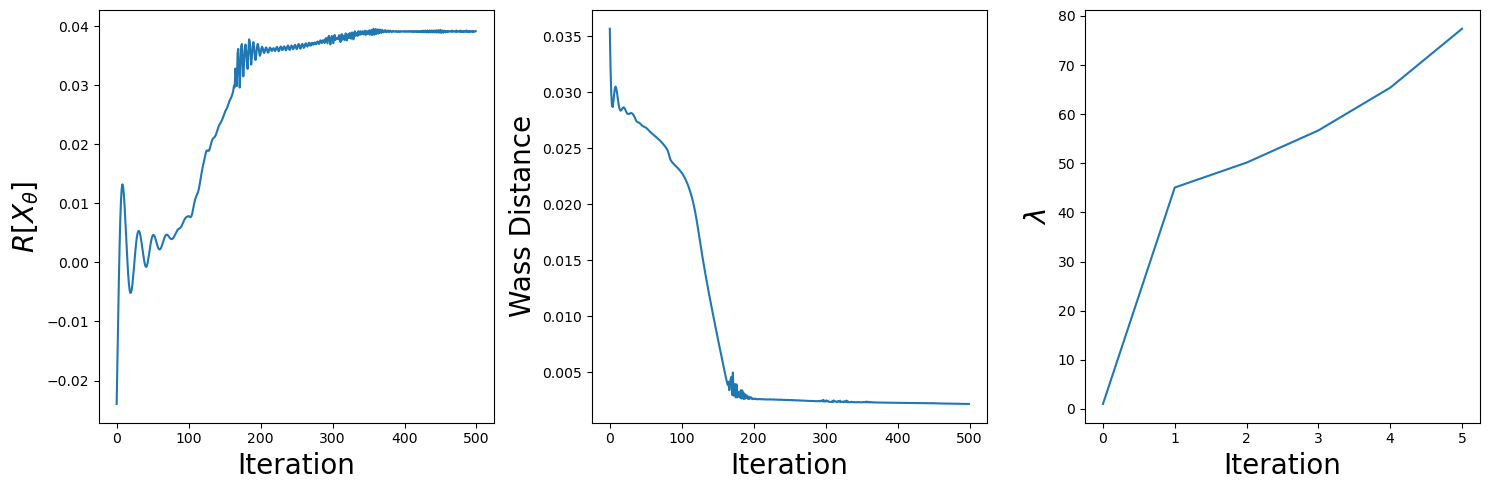

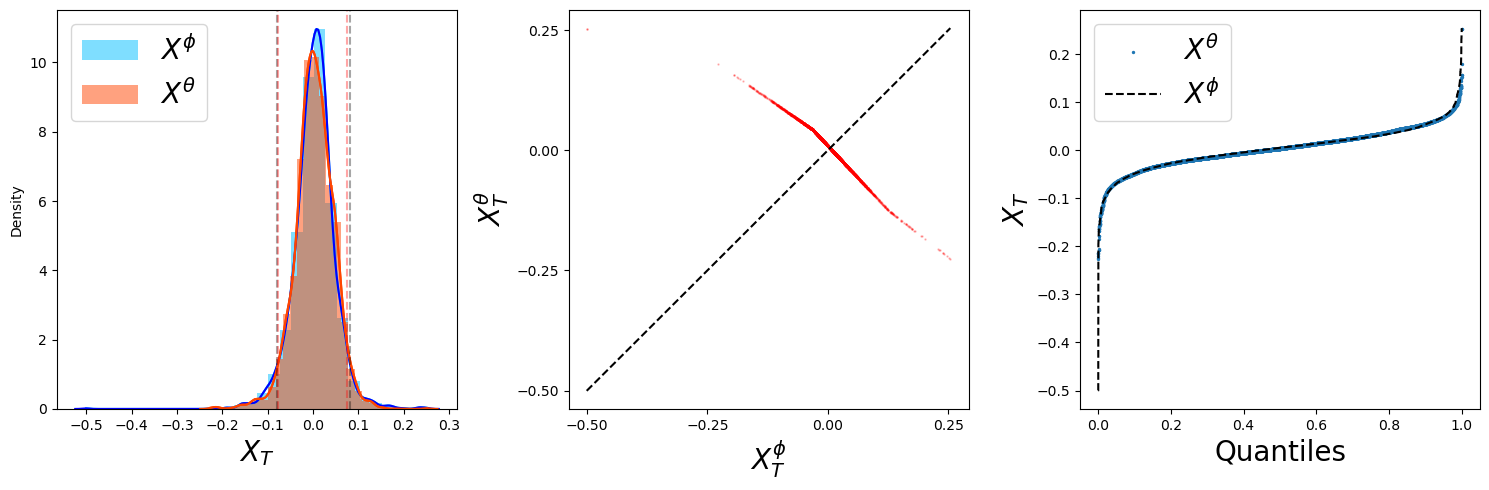

Outer Epoch: 40 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.18616222 0.09017289 0.25562394 0.03680273 0.06207938 0.08710574
 0.09257542 0.07325803 0.06852177 0.04769787]
Weights Delta:  [-0.00787824  0.00278047  0.00287575 -0.00146073 -0.00477754  0.00234941
 -0.00090506  0.00627268  0.00414893 -0.00340568]


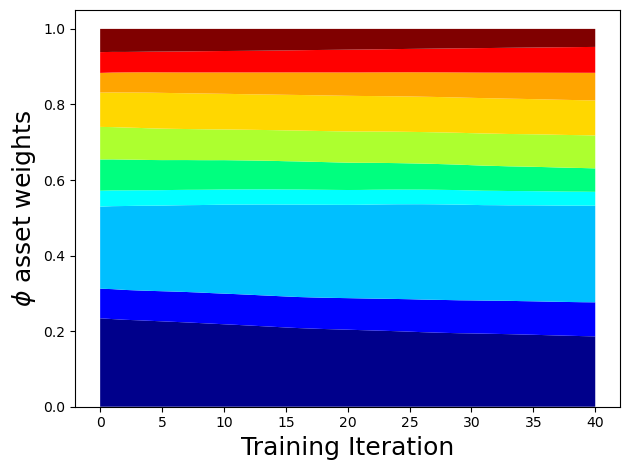

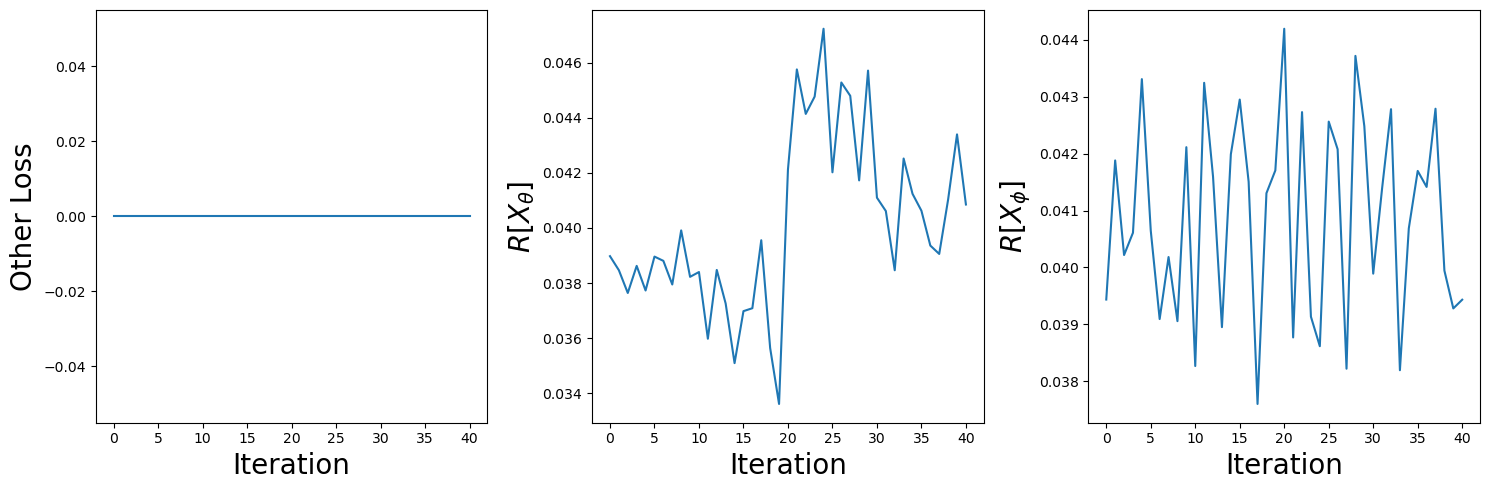

### Inner Problem Metrics ###
Wass Dist History:  [0.001144494628533721, 0.0011955591617152095, 0.0011493198107928038, 0.00122431805357337, 0.0011439911322668195]
Risk Measure X_theta History:  [0.04049524664878845, 0.04090970382094383, 0.04042971879243851, 0.04099695011973381, 0.0404471717774868]
Loss History:  [0.008477206341922283, -0.006230576895177364, 0.013159888796508312, -0.003055940382182598, 0.011164577677845955]
Augmented Lagrangian lambda: 9.947610108414665 mu: 15187.5


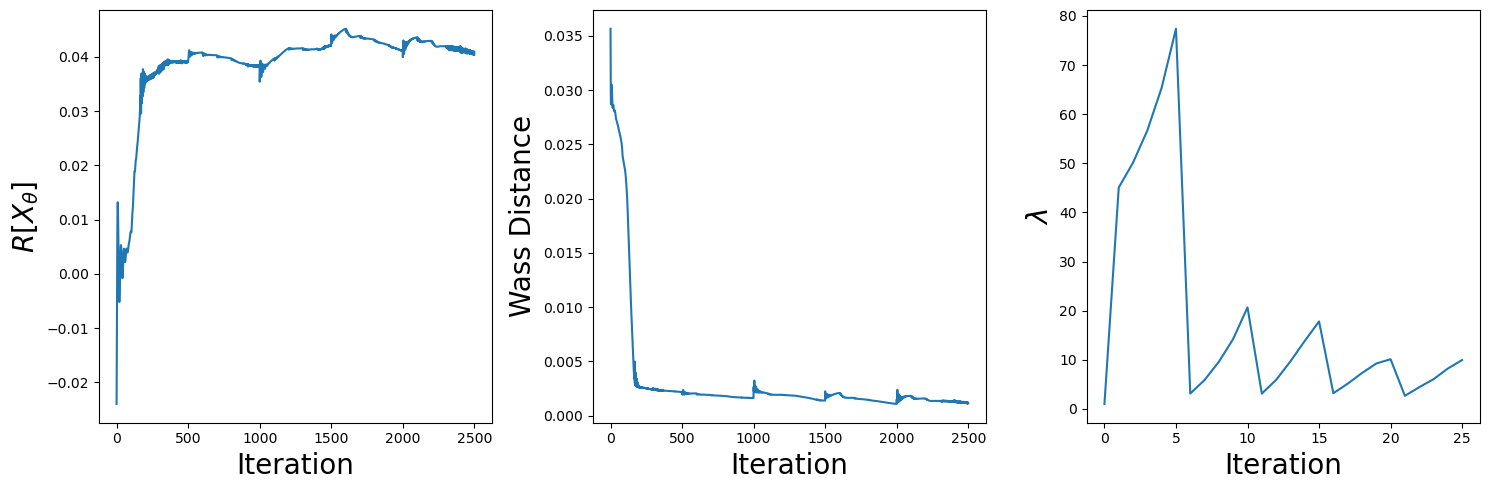

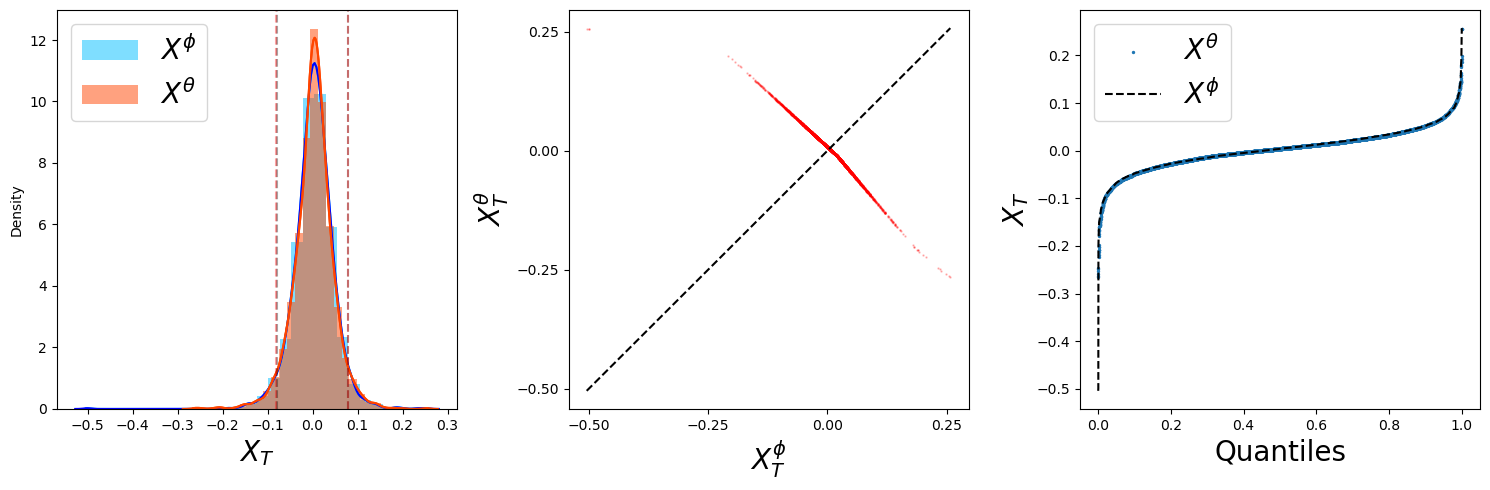

Outer Epoch: 80 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.1689782  0.09662773 0.25410989 0.03721349 0.04573995 0.08848043
 0.09124818 0.09817576 0.08505946 0.03436691]
Weights Delta:  [-0.00247465 -0.00093502 -0.0020434   0.0011989  -0.00325459  0.0007065
 -0.00112963  0.00541782  0.0052017  -0.0026876 ]


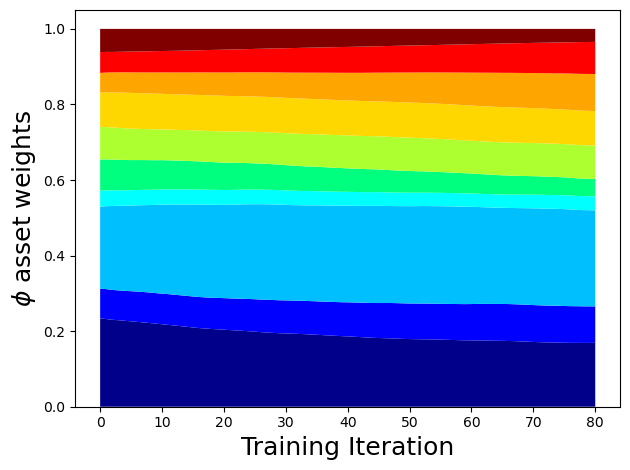

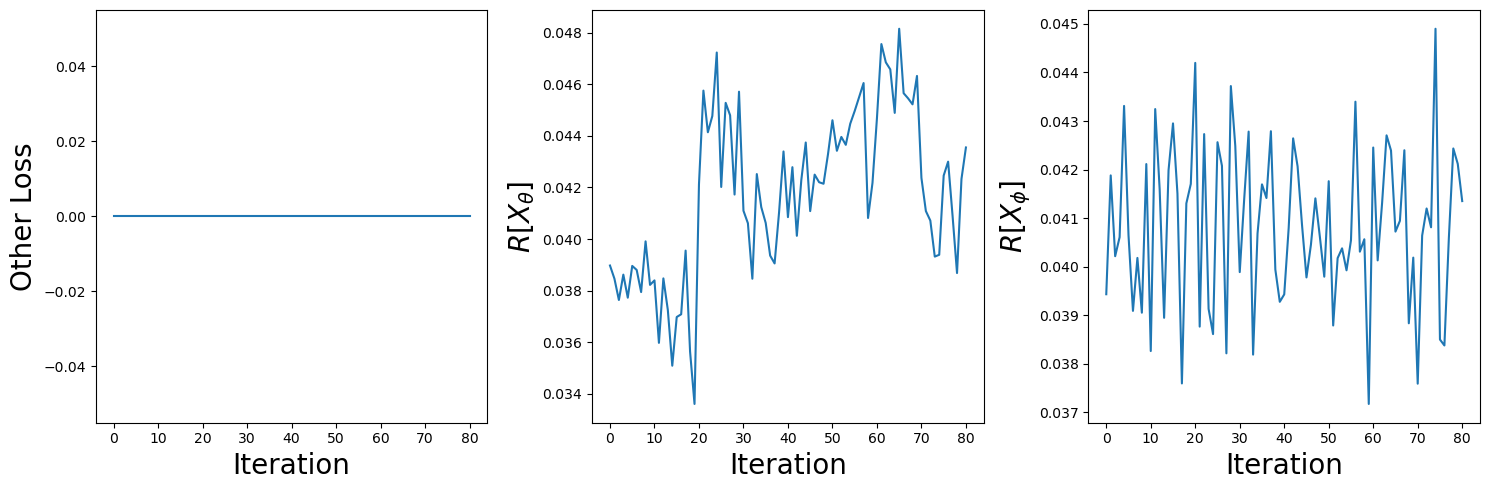

### Inner Problem Metrics ###
Wass Dist History:  [0.0010730454232543707, 0.0017679567681625485, 0.0010272057261317968, 0.0012281875824555755, 0.0012871152721345425]
Risk Measure X_theta History:  [0.04339147359132767, 0.044874511659145355, 0.04342038184404373, 0.043040089309215546, 0.044296976178884506]
Loss History:  [0.0628582313656807, -0.054808907210826874, 0.04749848321080208, 0.052764181047677994, -0.047583919018507004]
Augmented Lagrangian lambda: 11.500988449901342 mu: 15187.5


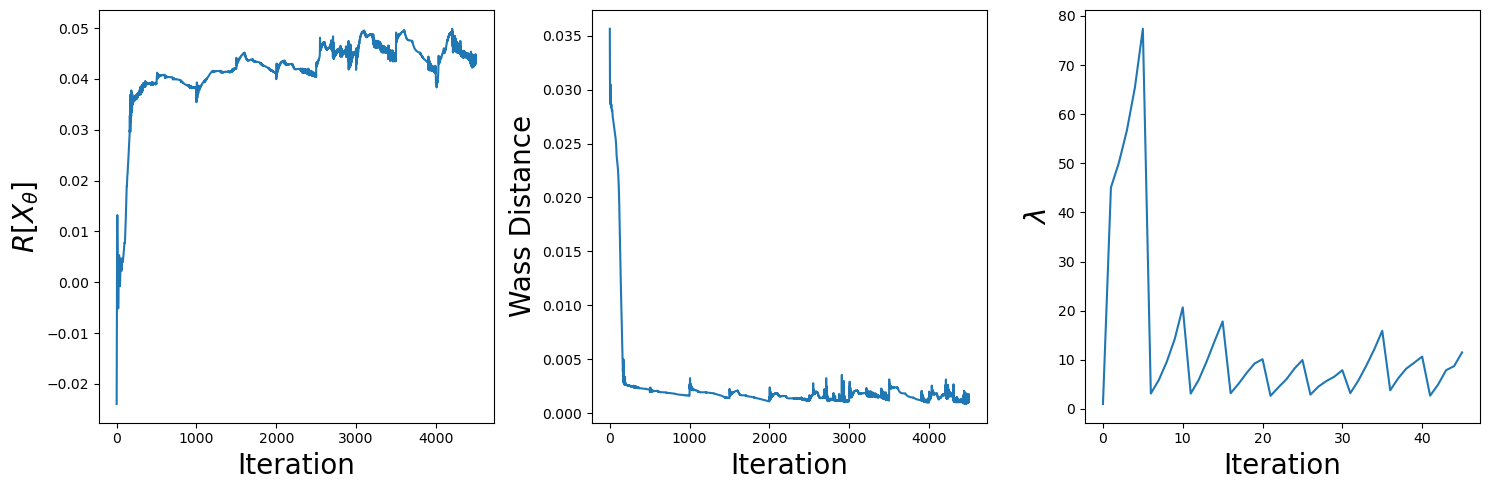

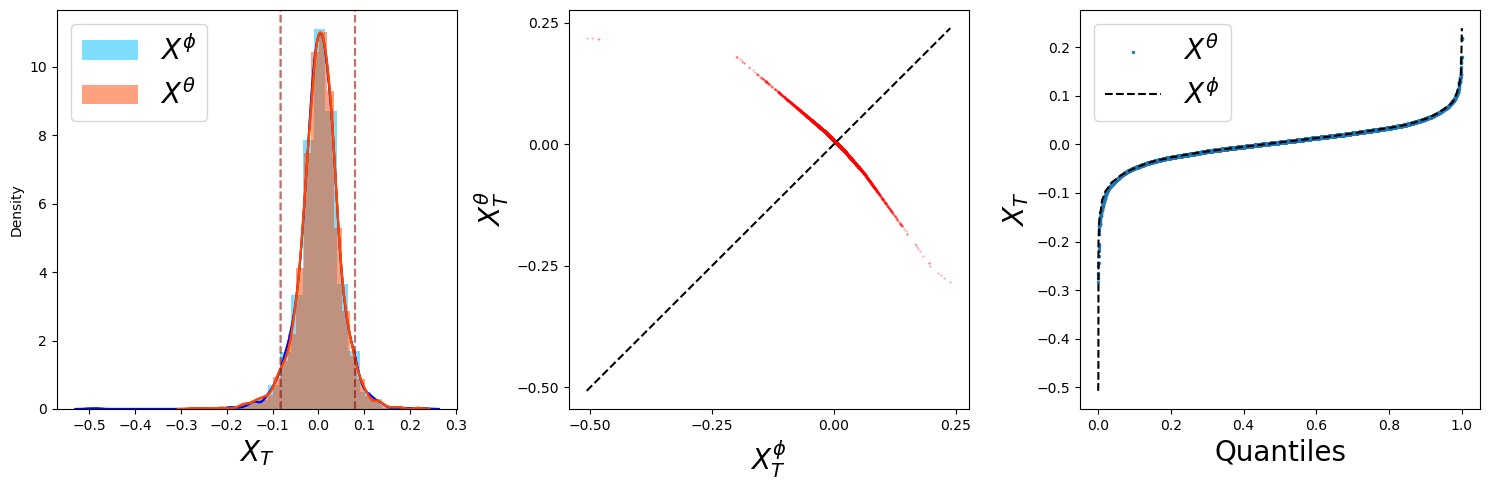

In [20]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.001"
outer_name = root_dir + "outer_ab_0.001"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_0, wass_params_0, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.001.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.001.npy", agent.X_phi_history)

### Wass 1e-2

In [21]:
LM_param_dict = { "lam": 1,
                  "mu": 200,
                  "mu_update": 1.5,
                  "update_freq": 100
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-2
                  }

lm_params_1 = LM_Params(LM_param_dict)
wass_params_1 = Wass_Params(wass_param_dict)

Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.12085724 0.08894393 0.06004057 0.13464813 0.10838199 0.05671838
 0.07187229 0.04048369 0.05569308 0.26236072]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.010369776748120785, 0.010348871350288391, 0.010321265086531639, 0.010314008221030235, 0.010300557129085064]
Risk Measure X_theta History:  [0.08873670548200607, 0.0889202207326889, 0.08908980339765549, 0.08931960165500641, 0.08953550457954407]
Loss History:  [-0.059878844767808914, -0.060434550046920776, -0.06062562018632889, -0.06163147836923599, -0.0623040571808815]
Augmented Lagrangian lambda: 2.7448031781241298 mu: 1518.75


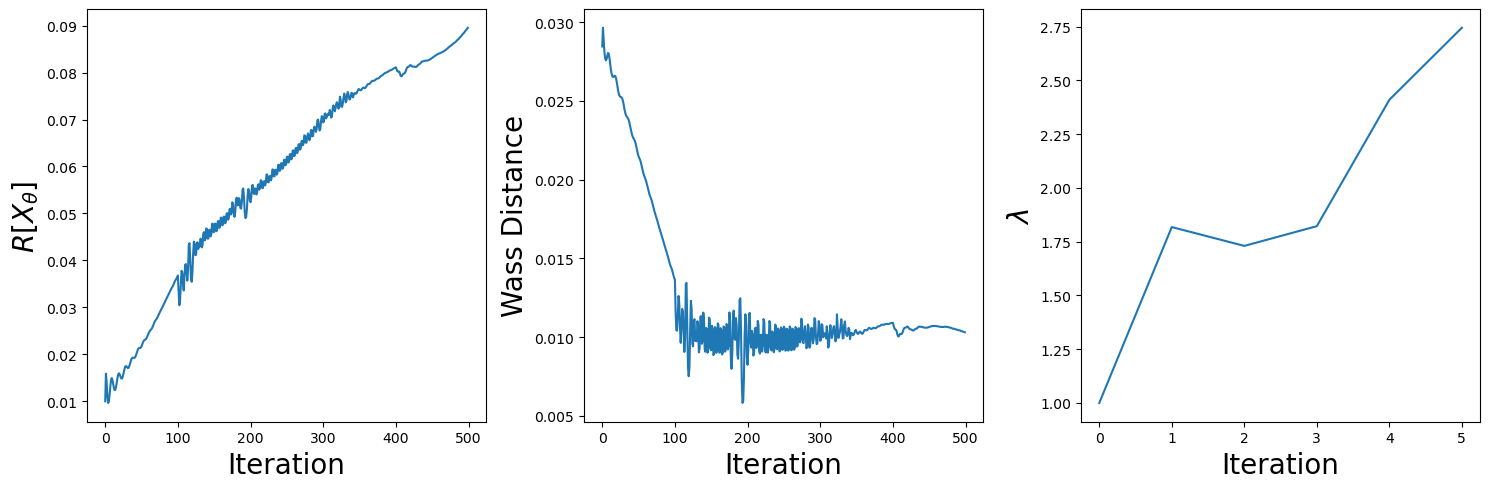

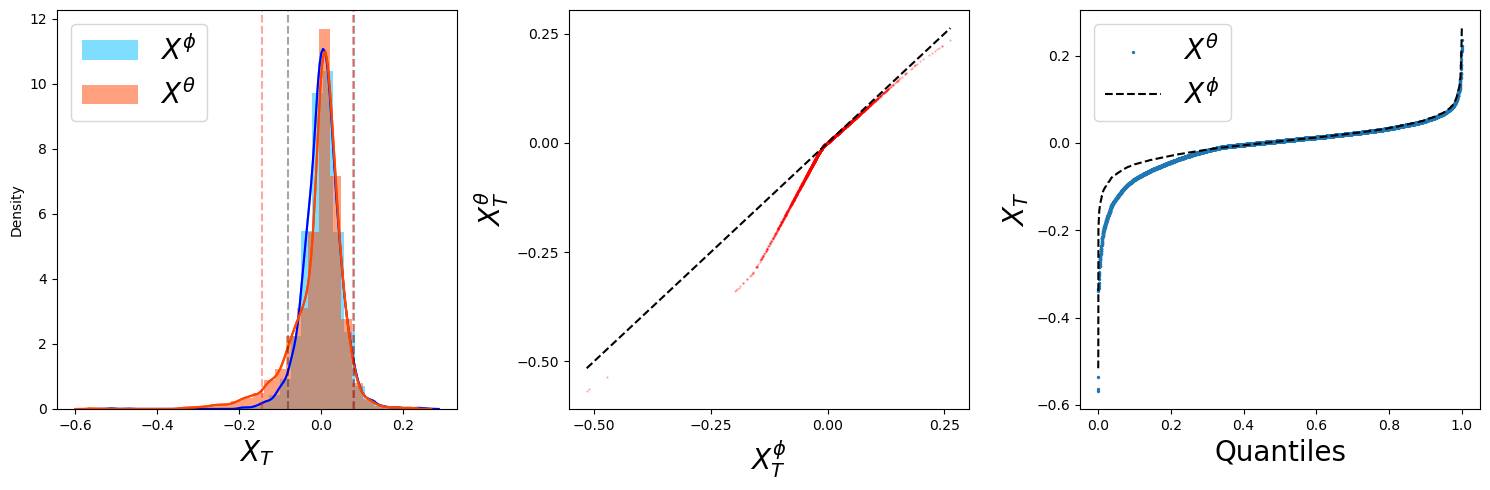

Outer Epoch: 40 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.09801858 0.07531103 0.08087353 0.10255894 0.14088015 0.05628745
 0.07778773 0.05400471 0.05934811 0.25492978]
Weights Delta:  [-0.00339985 -0.00207148  0.00488567 -0.00810793  0.00583118  0.0021938
  0.00355221  0.00481047  0.00274303 -0.01043707]


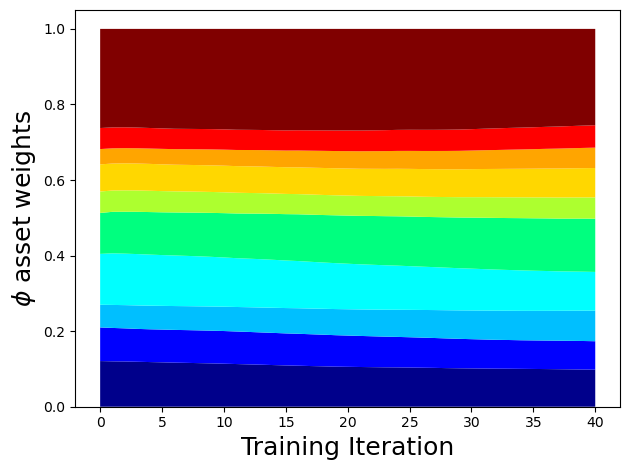

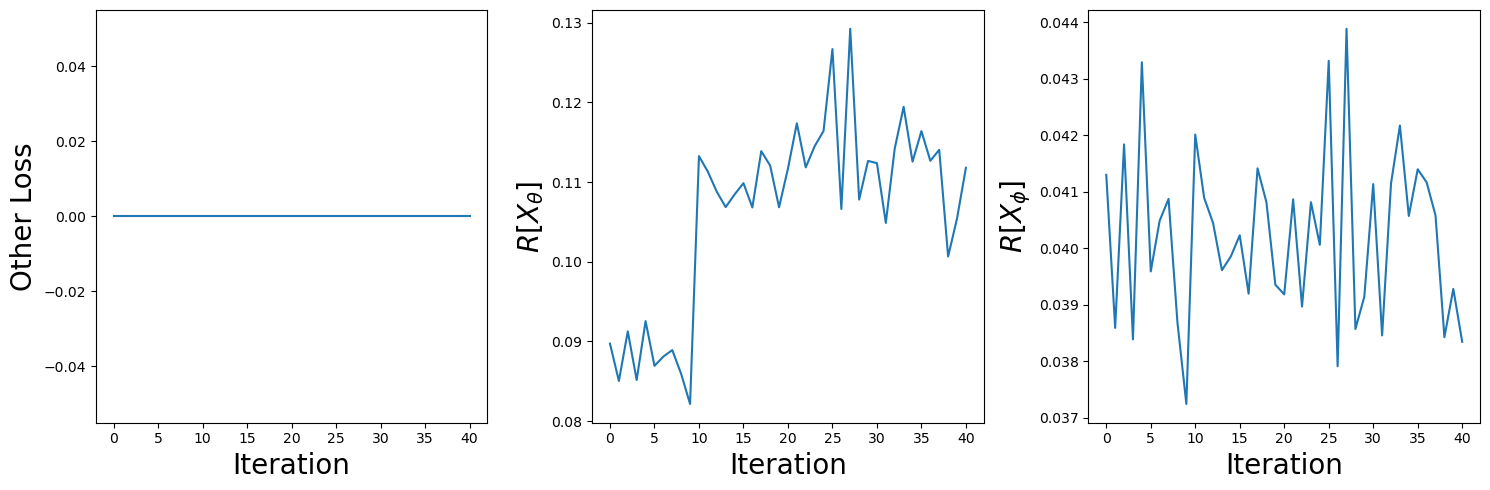

### Inner Problem Metrics ###
Wass Dist History:  [0.010318566113710403, 0.010063987225294113, 0.01028039027005434, 0.010342459194362164, 0.009996036067605019]
Risk Measure X_theta History:  [0.11196531355381012, 0.11253070086240768, 0.11188985407352448, 0.11253226548433304, 0.11164975166320801]
Loss History:  [0.11675343662500381, -0.09587473422288895, 0.11547430604696274, -0.05187126621603966, -0.11121261119842529]
Augmented Lagrangian lambda: 8.470653668977318 mu: 1518.75


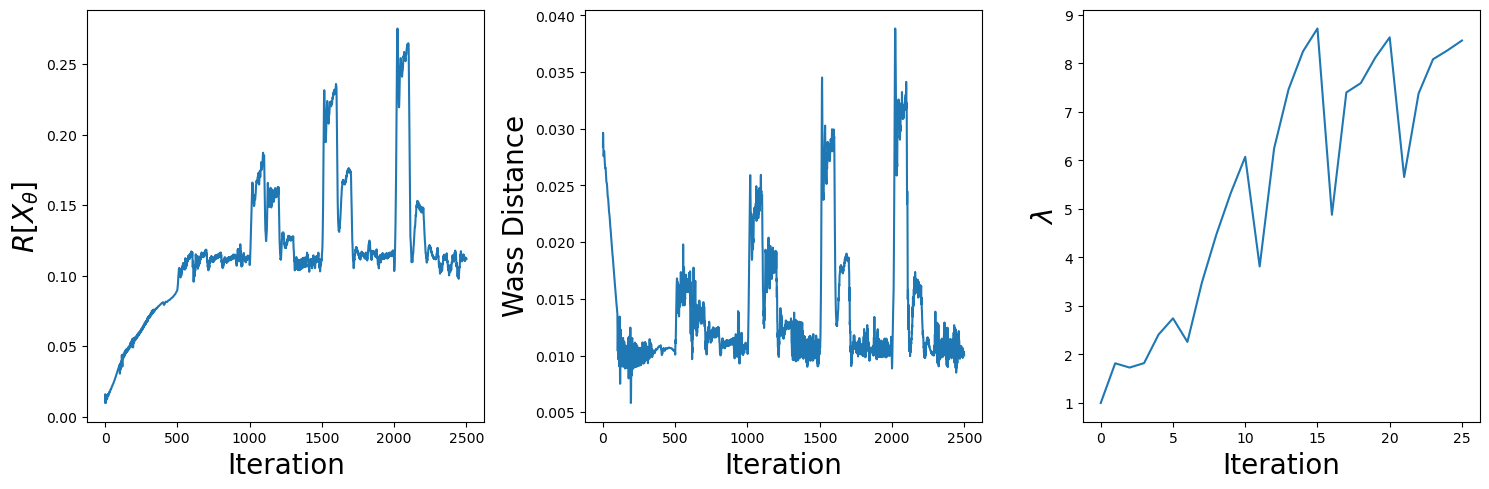

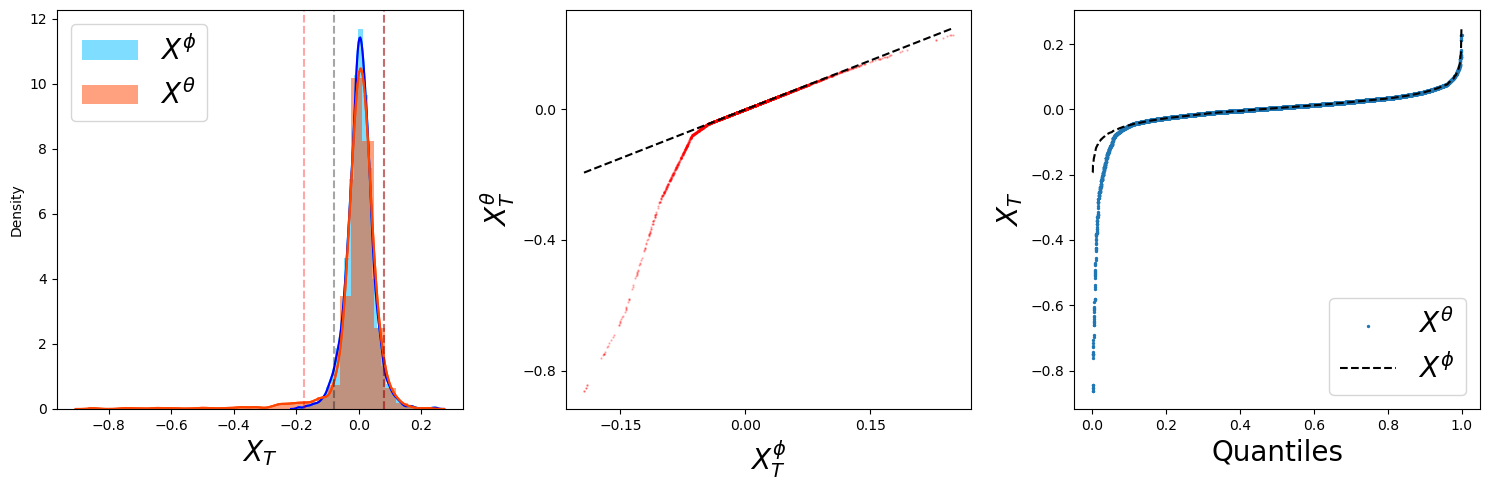

Outer Epoch: 80 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.08275817 0.07173326 0.10650556 0.08723343 0.14326964 0.06066638
 0.09091129 0.07100666 0.06593122 0.2199844 ]
Weights Delta:  [-0.00240082 -0.00168773  0.00656485 -0.00075331 -0.0040618   0.00329725
  0.00300933  0.00482833  0.00179332 -0.01058944]


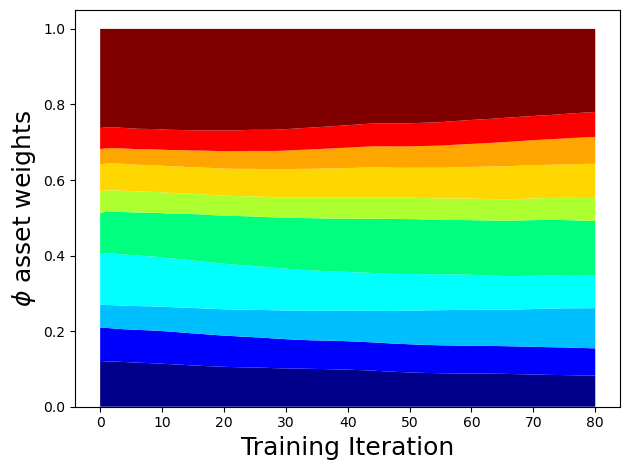

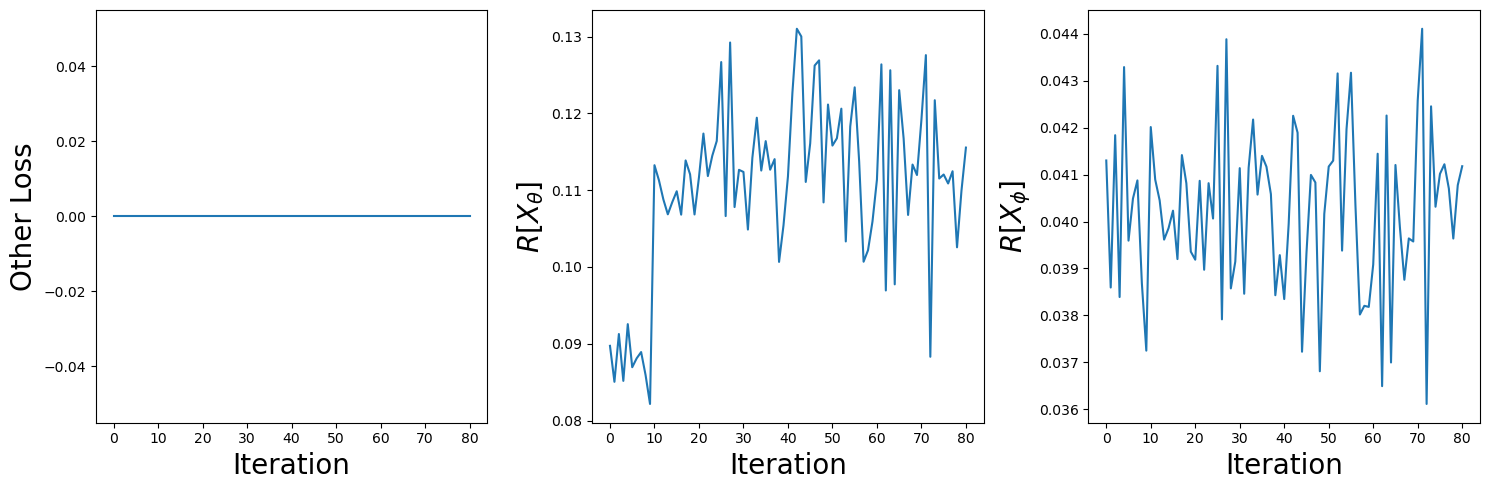

### Inner Problem Metrics ###
Wass Dist History:  [0.01129807811230421, 0.011051376350224018, 0.010711725801229477, 0.010689499787986279, 0.010516135022044182]
Risk Measure X_theta History:  [0.1186455711722374, 0.11805056780576706, 0.11615809798240662, 0.1155930757522583, 0.11621619760990143]
Loss History:  [-0.04015755653381348, -0.04388774186372757, 0.12003811448812485, 0.12001383304595947, -0.05101136118173599]
Augmented Lagrangian lambda: 8.841811365913598 mu: 1518.75


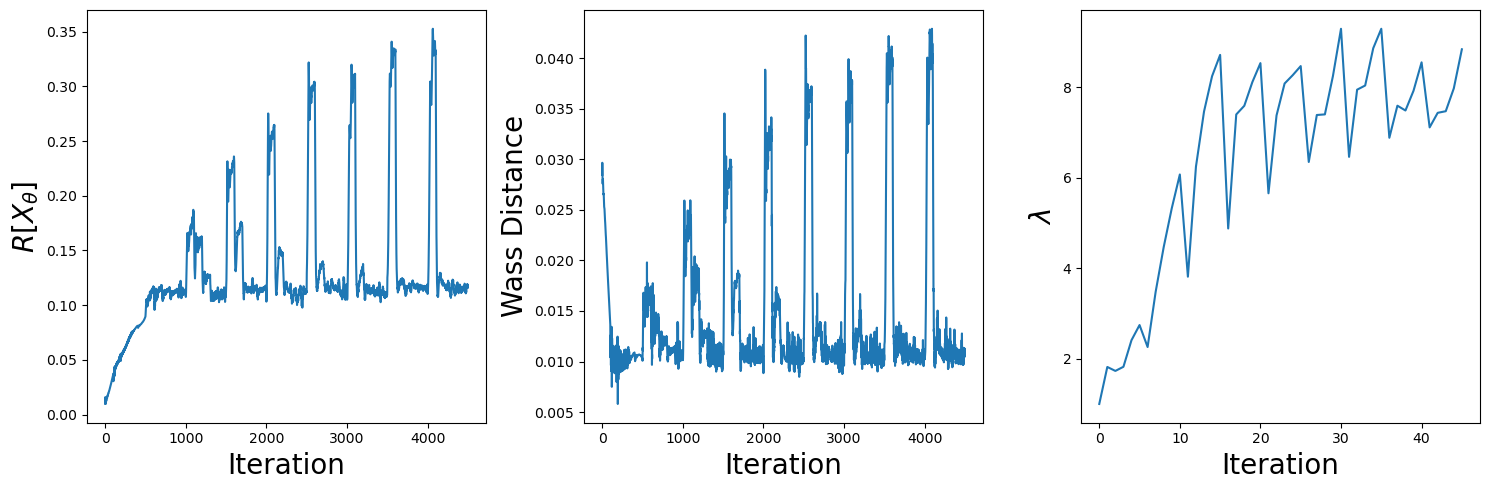

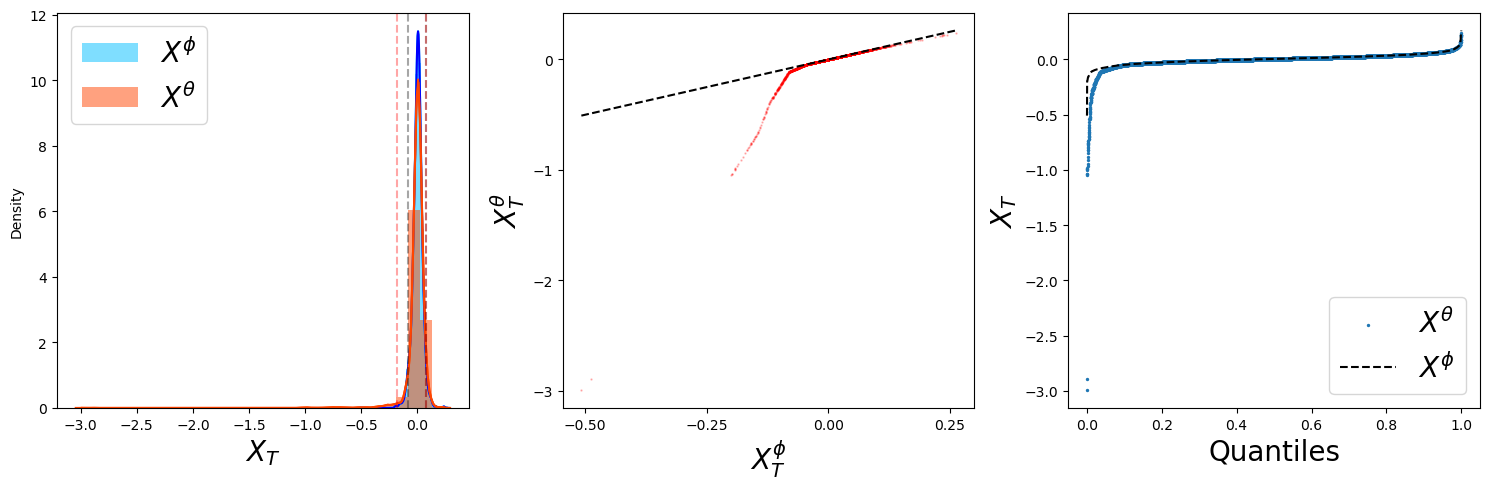

In [22]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.01"
outer_name = root_dir + "outer_ab_0.01"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_1, wass_params_1, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.01.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.01.npy", agent.X_phi_history)

### Wass 1e-1

In [23]:
LM_param_dict = { "lam": 1,
                  "mu": 20,
                  "mu_update": 1.5,
                  "update_freq": 100
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1e-1
                  }

lm_params_2 = LM_Params(LM_param_dict)
wass_params_2 = Wass_Params(wass_param_dict)

Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.1057863  0.10660437 0.12002864 0.06465582 0.05702635 0.14375353
 0.07164689 0.14591821 0.13334931 0.05123055]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [0.10615862905979156, 0.10633288323879242, 0.10643663257360458, 0.1064658835530281, 0.10644526779651642]
Risk Measure X_theta History:  [0.434406578540802, 0.43594983220100403, 0.43736204504966736, 0.438632607460022, 0.4398067593574524]
Loss History:  [-0.20314888656139374, -0.20232465863227844, -0.2022469937801361, -0.20298168063163757, -0.20421677827835083]
Augmented Lagrangian lambda: 1.8640918582677828 mu: 151.875


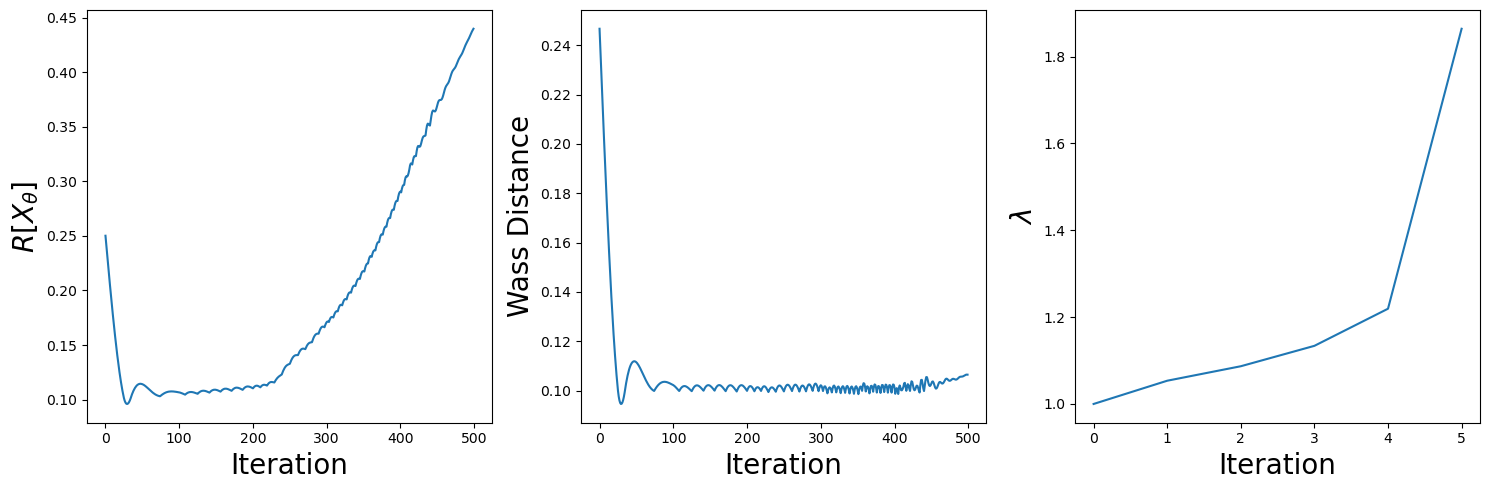

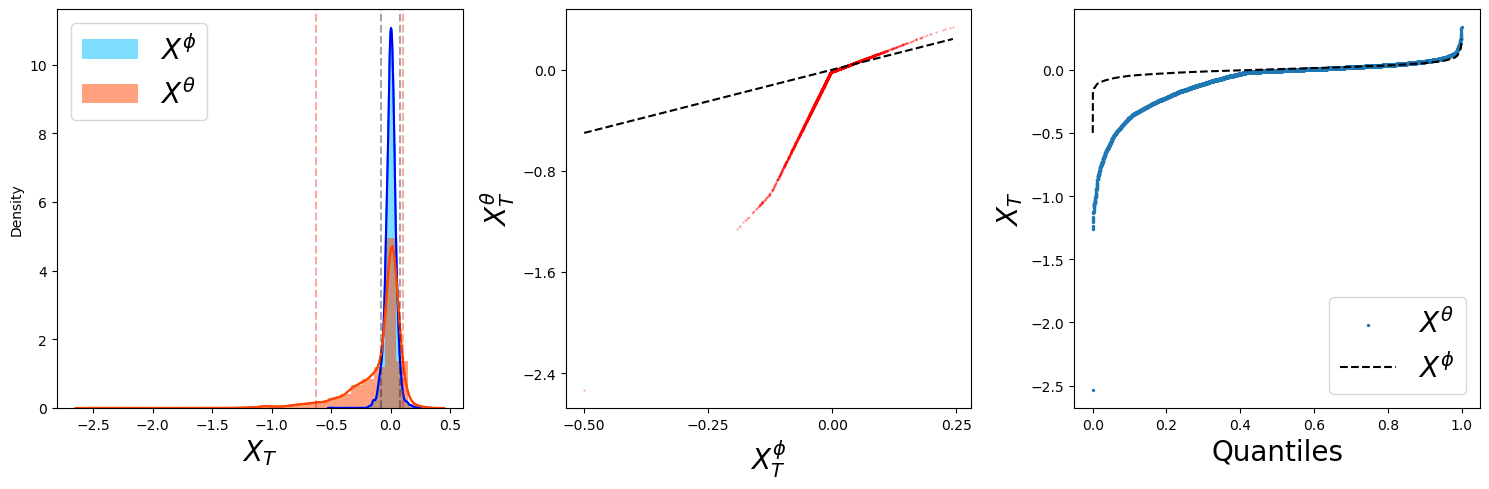

Outer Epoch: 40 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.08548685 0.08882012 0.18462218 0.06850117 0.08170976 0.11299366
 0.06341518 0.13781972 0.10395195 0.07267943]
Weights Delta:  [-0.0024486  -0.002621    0.01411042 -0.00073286  0.00441346 -0.00491323
 -0.00235306 -0.00261714 -0.00570905  0.00287107]


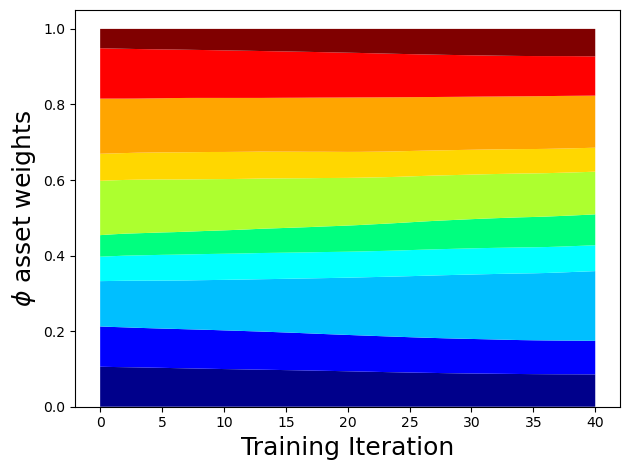

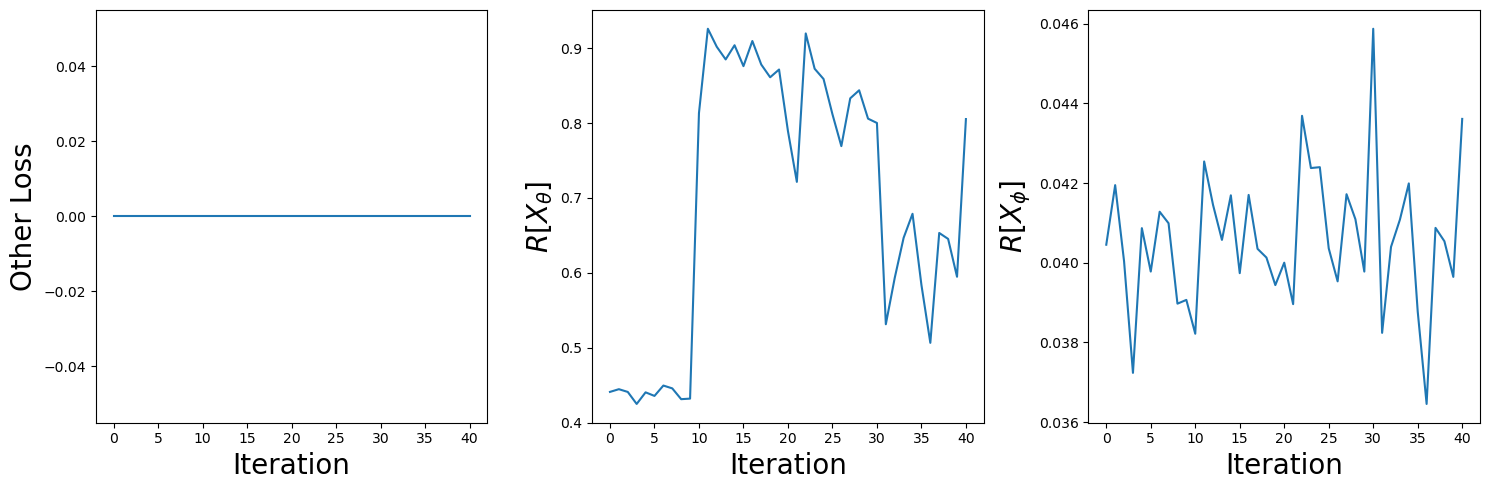

### Inner Problem Metrics ###
Wass Dist History:  [0.10314781218767166, 0.1044187843799591, 0.10328487306833267, 0.10257751494646072, 0.10401390492916107]
Risk Measure X_theta History:  [0.7941874861717224, 0.7951672077178955, 0.79852694272995, 0.8040393590927124, 0.8062502145767212]
Loss History:  [0.15446853637695312, 0.17894482612609863, 0.1530361771583557, 0.01571042463183403, 0.03991274908185005]
Augmented Lagrangian lambda: 8.15001673065126 mu: 151.875


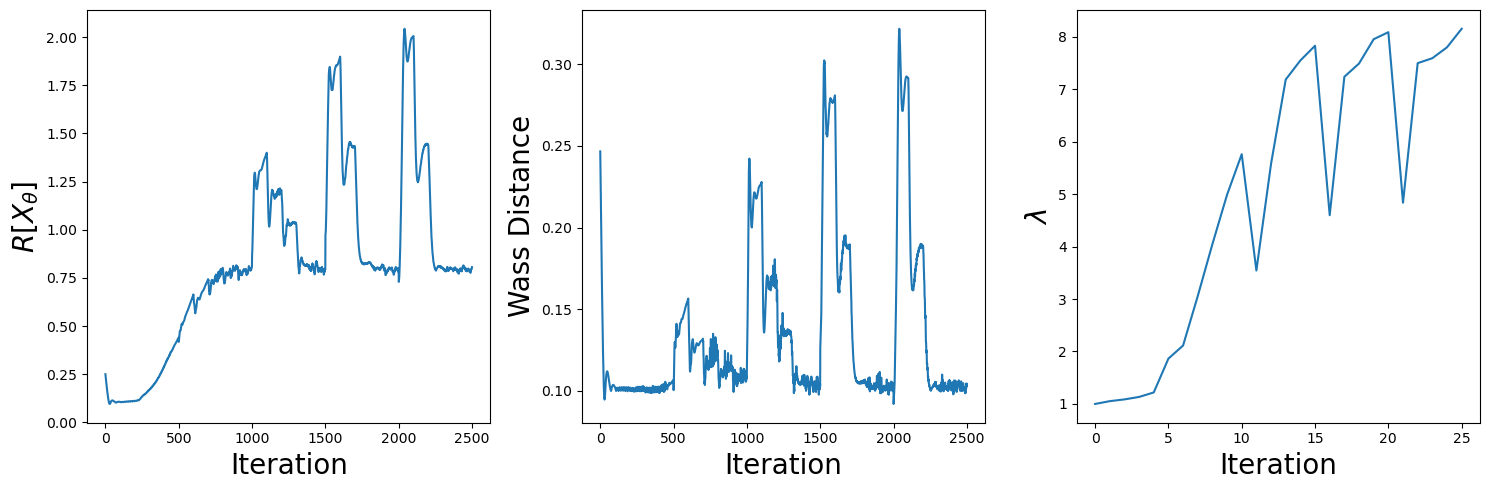

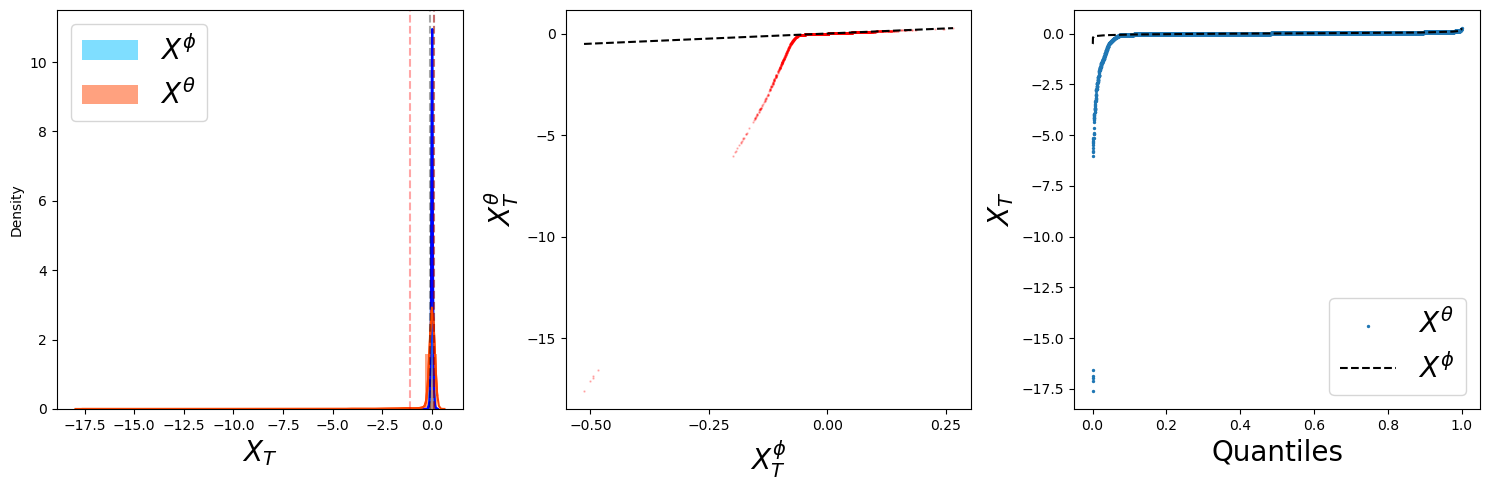

Outer Epoch: 80 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.07481817 0.07970428 0.20691355 0.07240656 0.08963805 0.10078268
 0.06387972 0.1526204  0.08295823 0.07627836]
Weights Delta:  [-0.00353635 -0.00206258  0.00236005  0.00075454  0.00395411 -0.00348129
  0.00172704  0.005156   -0.00360637 -0.00126506]


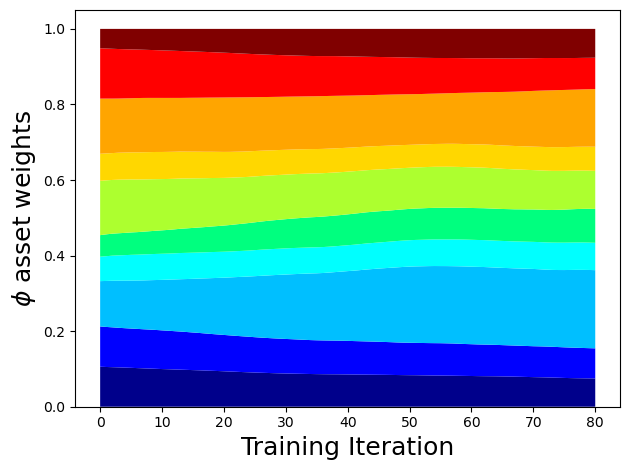

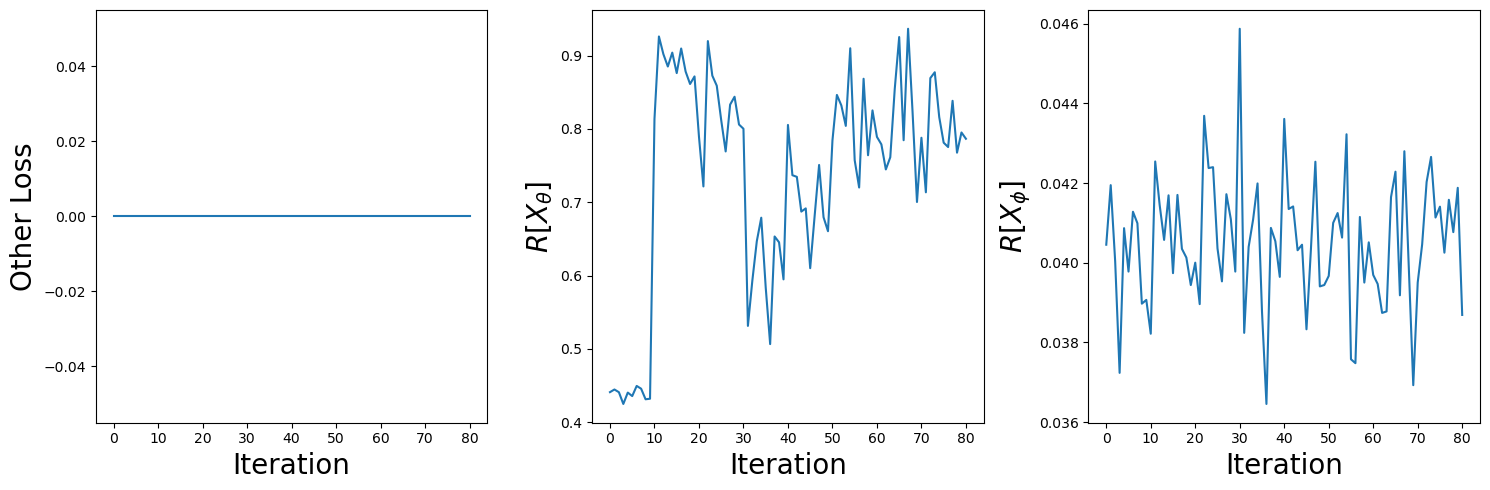

### Inner Problem Metrics ###
Wass Dist History:  [0.10363350063562393, 0.1020560935139656, 0.10166719555854797, 0.10310904681682587, 0.10228326171636581]
Risk Measure X_theta History:  [0.7853116989135742, 0.7867896556854248, 0.7904667854309082, 0.7915136814117432, 0.790097177028656]
Loss History:  [0.160870760679245, 0.12839871644973755, -0.012556815519928932, 0.012208681553602219, -0.0011945615988224745]
Augmented Lagrangian lambda: 7.93064079992473 mu: 151.875


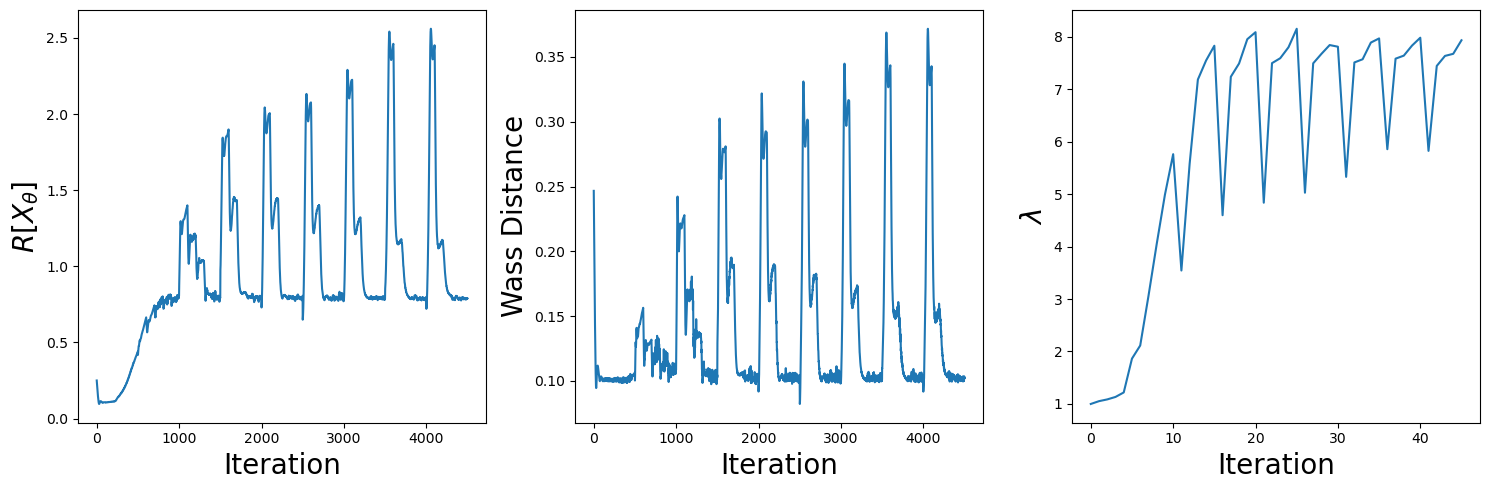

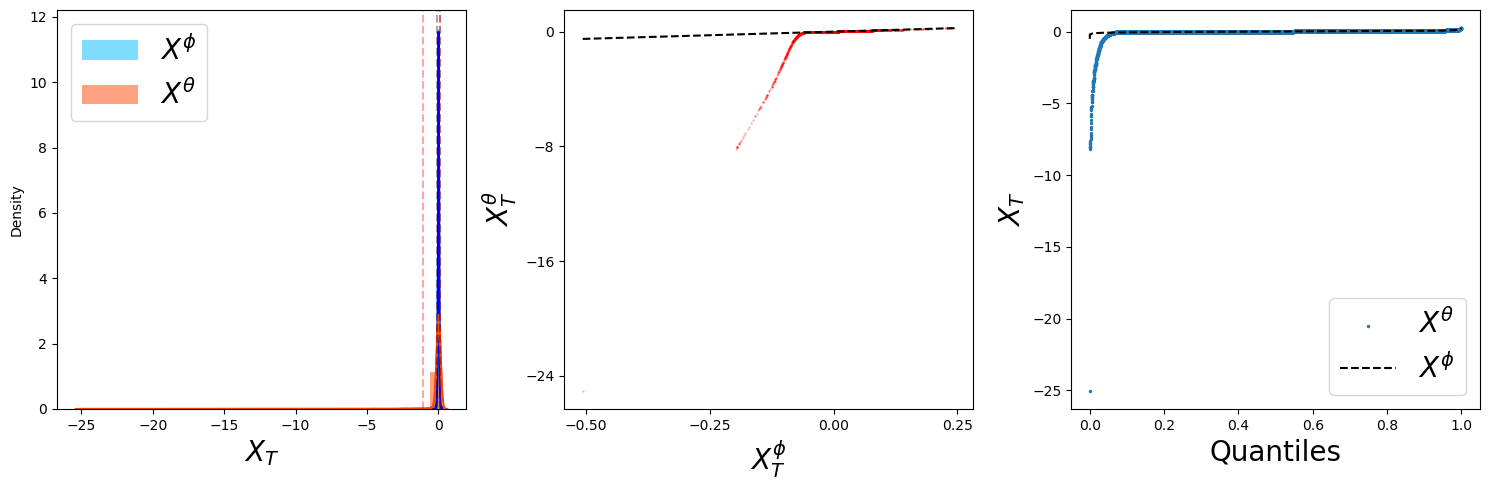

In [24]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_0.1"
outer_name = root_dir + "outer_ab_0.1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_2, wass_params_2, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_0.1.npy", agent.weights_history)
np.save(root_dir + "X_phi_0.1.npy", agent.X_phi_history)

### Wass 1

In [25]:
LM_param_dict = { "lam": 1,
                  "mu": 2,
                  "mu_update": 1.5,
                  "update_freq": 100
                  }
wass_param_dict = {"wass_order" : 1,
                   "wass_limit" : 1
                  }

lm_params_3 = LM_Params(LM_param_dict)
wass_params_3 = Wass_Params(wass_param_dict)

Outer Epoch: 0 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.05652464 0.11036588 0.15025498 0.04118353 0.08507664 0.10699385
 0.08207348 0.1636194  0.15007874 0.05382885]
Weights Delta:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
### Inner Problem Metrics ###
Wass Dist History:  [1.0010887384414673, 1.0000675916671753, 0.9990512728691101, 1.0008517503738403, 1.0023635625839233]
Risk Measure X_theta History:  [1.0992298126220703, 1.0985974073410034, 1.0979686975479126, 1.1003074645996094, 1.1023424863815308]
Loss History:  [0.001307502738200128, -0.009506591595709324, -1.0980676412582397, -0.002457092283293605, 0.012460260652005672]
Augmented Lagrangian lambda: 1.0987454727292059 mu: 15.1875


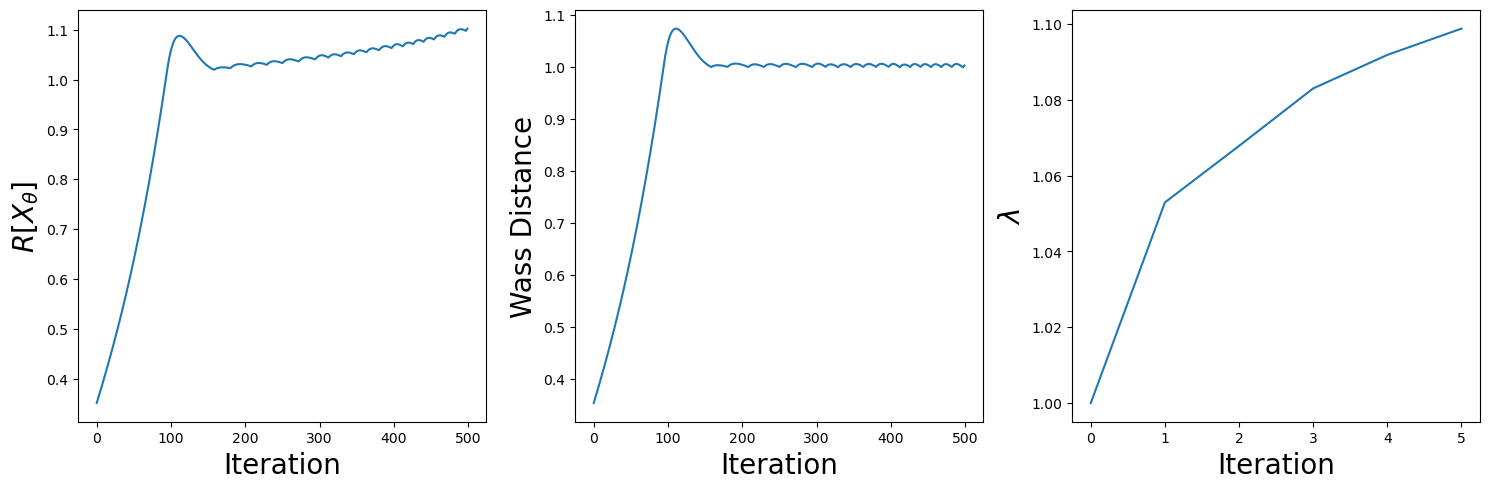

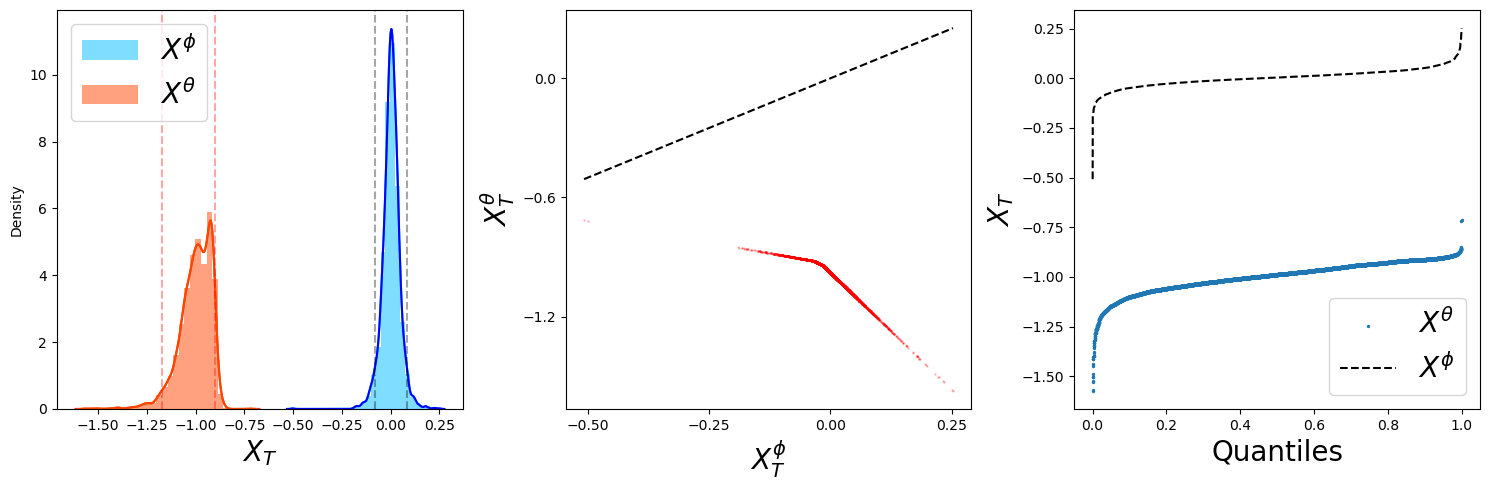

Outer Epoch: 40 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.05953995 0.09461972 0.24617107 0.03869164 0.06967363 0.09462036
 0.0686366  0.13549803 0.14474913 0.04779989]
Weights Delta:  [ 0.00295919 -0.00275287  0.02151646 -0.00061884 -0.00594597 -0.00324518
 -0.0029527  -0.00357339 -0.00144392 -0.00394281]


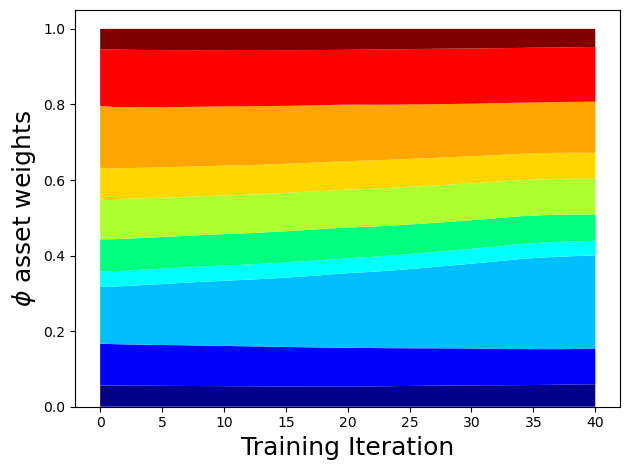

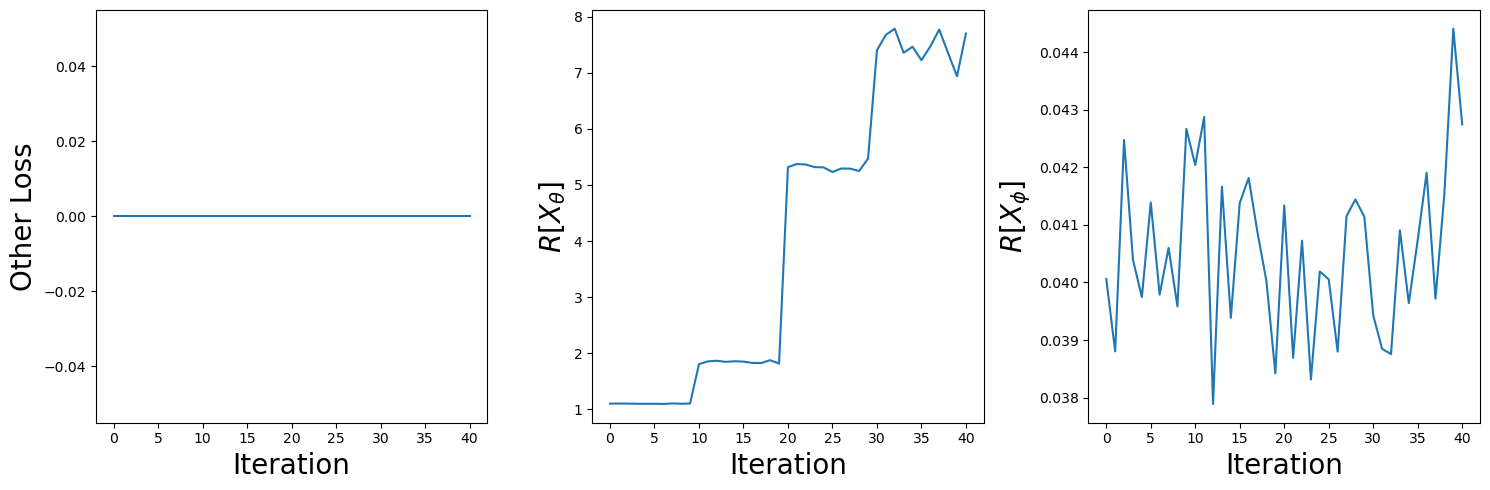

### Inner Problem Metrics ###
Wass Dist History:  [1.0246119499206543, 1.0288022756576538, 1.0322046279907227, 1.0348496437072754, 1.036792278289795]
Risk Measure X_theta History:  [7.594779968261719, 7.6259684562683105, 7.651325225830078, 7.67106294631958, 7.685571670532227]
Loss History:  [0.22256232798099518, 0.26623857021331787, 0.3019527196884155, 0.3299314081668854, 0.3506059944629669]
Augmented Lagrangian lambda: 7.791049662232399 mu: 15.1875


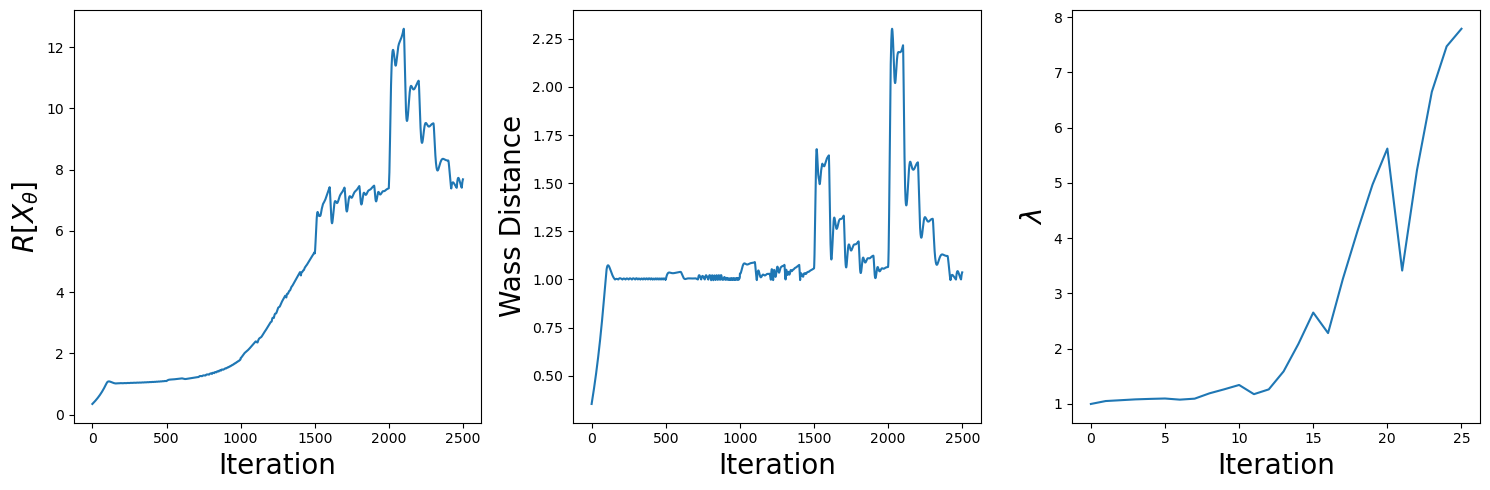

d:\Anaconda\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\envs\torch\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


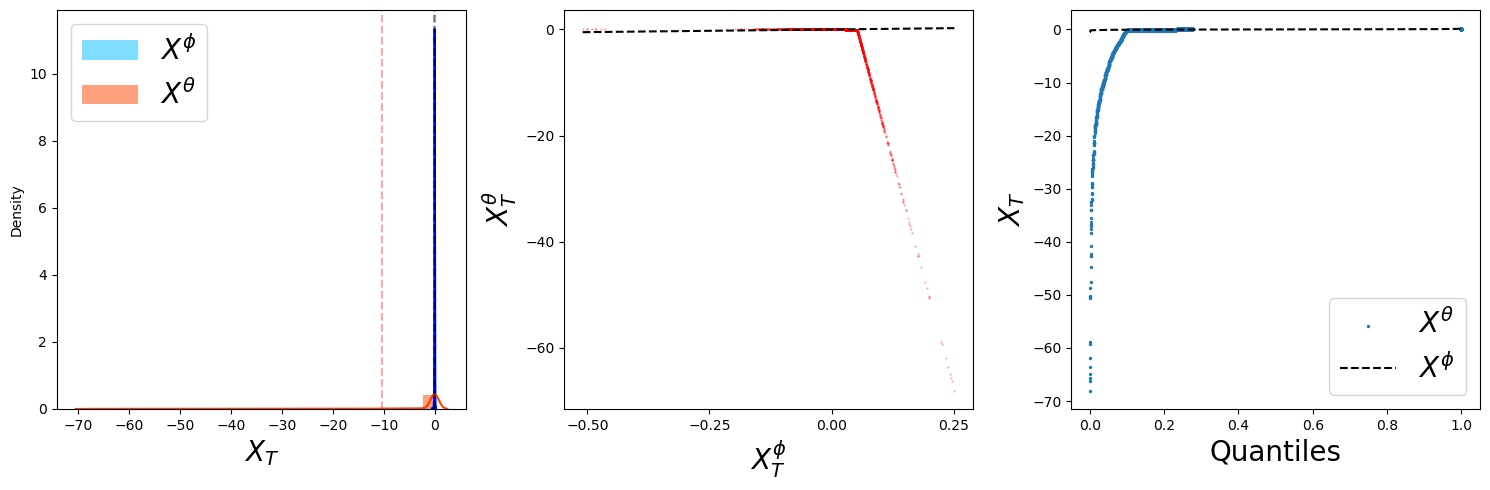

Outer Epoch: 80 Outer Iter: 0
### Outer Problem Metrics ###
Weights:  [0.07600226 0.10053361 0.23715581 0.03414611 0.04580121 0.10038379
 0.06559766 0.14277577 0.16451004 0.03309371]
Weights Delta:  [ 0.00402533 -0.00027061  0.00557007 -0.0007597  -0.00419124  0.00083514
 -0.00078107 -0.00396135  0.00220661 -0.00267322]


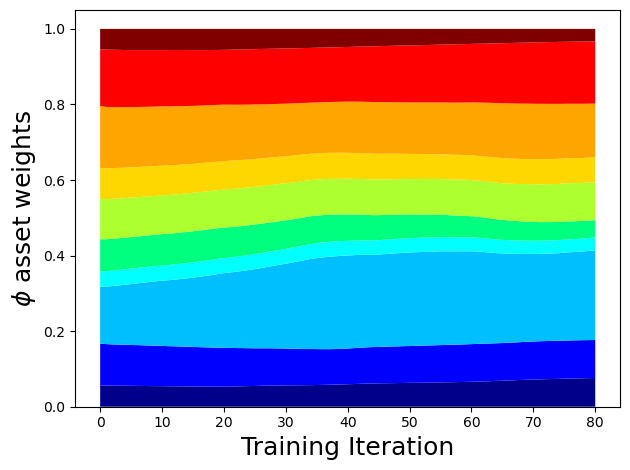

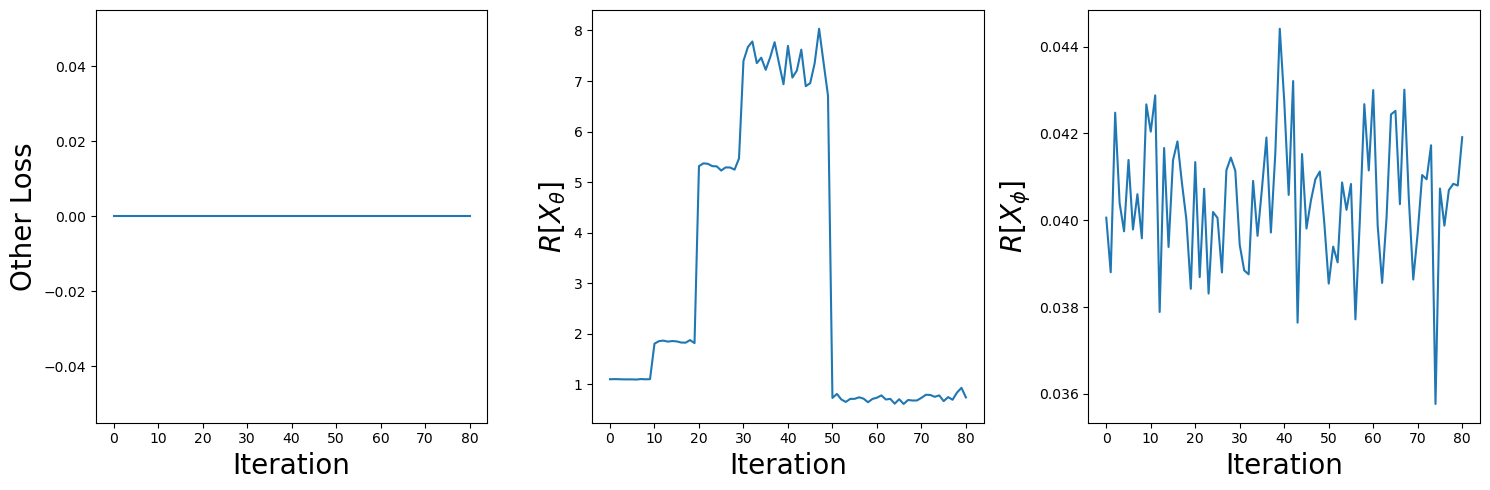

### Inner Problem Metrics ###
Wass Dist History:  [1.0147719383239746, 1.015466570854187, 1.0159602165222168, 1.0162723064422607, 1.016420841217041]
Risk Measure X_theta History:  [0.7435823082923889, 0.7439977526664734, 0.7442406415939331, 0.7443373203277588, 0.7443081736564636]
Loss History:  [0.24347293376922607, 0.25063851475715637, 0.25580278038978577, 0.2590807378292084, 0.26067835092544556]
Augmented Lagrangian lambda: 7.7568256765604024 mu: 15.1875


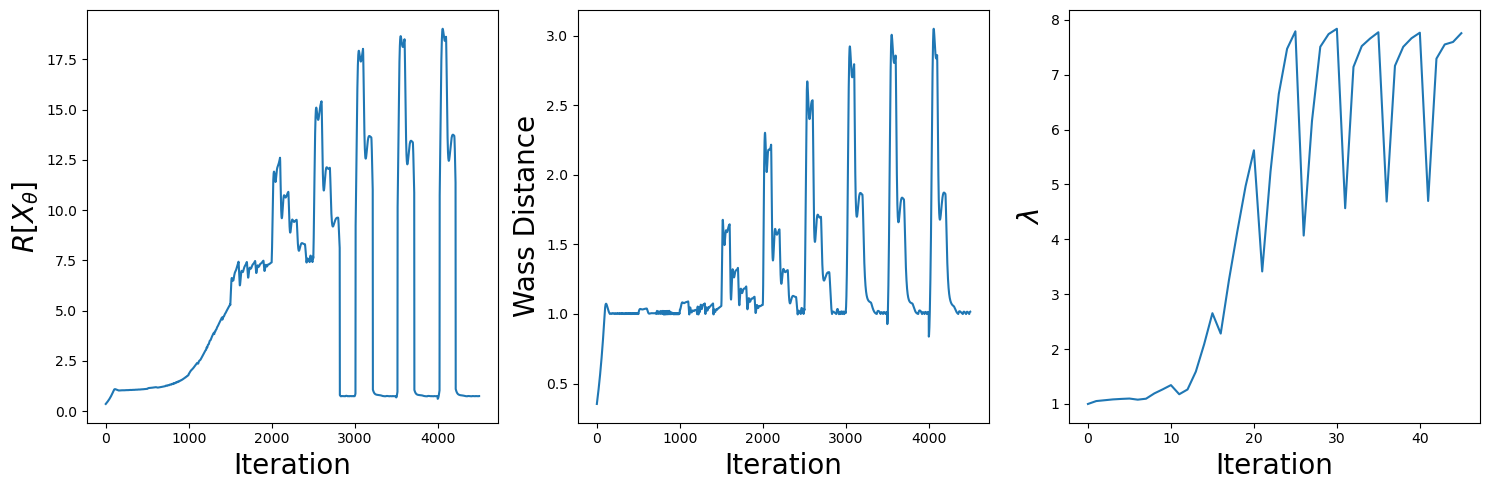

d:\Anaconda\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\envs\torch\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


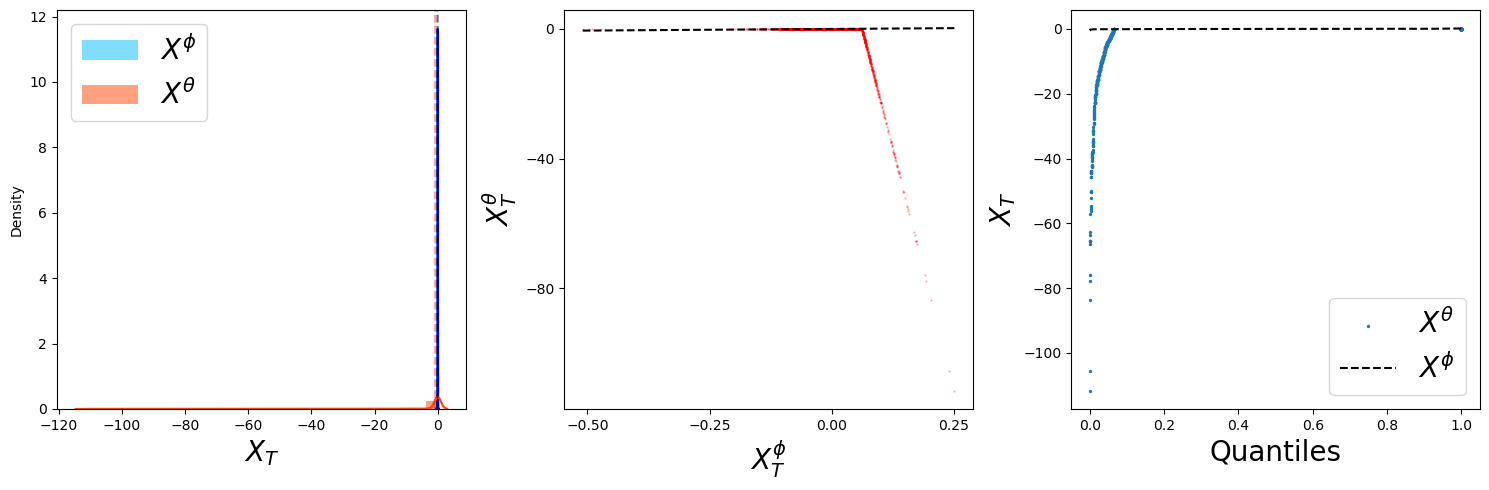

In [26]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(10).to(device)
inner_name = root_dir + "inner_ab_1"
outer_name = root_dir + "outer_ab_1"

agent = Robust_Agent(factor_model, sim_params, train_params, device, outer_net, outer_name)
adversary = Robust_Adversary(rm_params, lm_params_3, wass_params_3, train_params, device, inner_net, inner_name)
agent.train(adversary)
np.save(root_dir + "weights_1.npy", agent.weights_history)
np.save(root_dir + "X_phi_1.npy", agent.X_phi_history)

# Additional Plots

## Strategy Plots

In [27]:
import matplotlib as mpl
from matplotlib.cm import coolwarm

In [28]:
def PlotStrategy(model_names, wass_iter, outer_net, Nassets):
  num_model = len(model_names)
  weights_history = np.zeros((Nassets, num_model))
  # find strategy weights for each model
  for i in range(num_model):
    zero_tensor = torch.zeros(1).to(device)
    outer_net.load_state_dict(torch.load(root_dir + model_names[i]))
    weights = outer_net(zero_tensor).reshape(-1, 1)
    weights_np = weights.cpu().detach().numpy().squeeze()
    weights_history[:, i] = weights_np

  fig, ax = plt.subplots(figsize = (6,5))
  ax.tick_params(axis='both', labelsize=16)
  colors = ['darkblue', 'blue', 'deepskyblue', 'cyan', 'springgreen', 'greenyellow', 'gold', 'orange', 'red', 'maroon']
  cmap = (mpl.colors.ListedColormap(colors))
  plt.stackplot(wass_iter, weights_history, colors = colors)
  plt.xlabel(r"$\epsilon$", fontsize = 18)
  plt.ylabel(r" $\phi$ portfolio weights", fontsize = 18)
  plt.xscale('log')
  # ensure 10 assets show up in color bar
  bounds = [i for i in range(1,12)]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  # 创建 ScalarMappable 对象
  sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
  # sm.set_array([])  # 设置空数组以避免警告
  # 添加颜色条
  cbar = plt.colorbar(sm, ax=ax)  # 使用 ax 参数
  cbar.set_label('Assets', rotation=270, labelpad=18, fontsize=18)
  # re-centre color bar labels
  labels = np.arange(1,11,1)
  loc    = labels + .5
  cbar.set_ticks(loc)
  cbar.set_ticklabels(labels)
  cbar.ax.tick_params(labelsize=16)
  plt.tight_layout()
  plt.show()


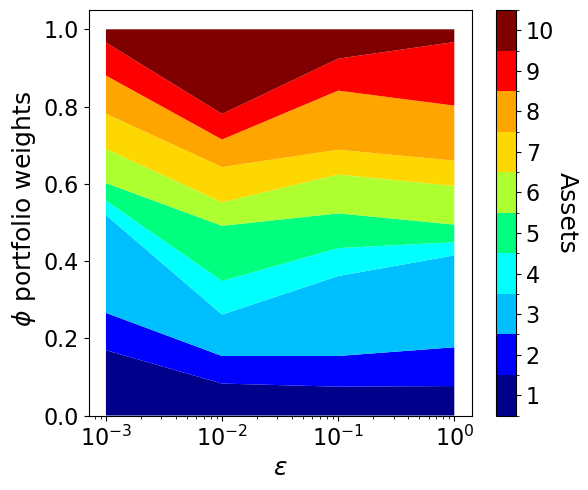

In [29]:
model_names = ["outer_ab_0.001_Epoch_80_Iter_0", "outer_ab_0.01_Epoch_80_Iter_0", "outer_ab_0.1_Epoch_80_Iter_0", "outer_ab_1_Epoch_80_Iter_0"]
wass_iter = [1e-3, 1e-2, 1e-1, 1e-0]
outer_net = OuterNet(10).to(device)
Nassets = 10
PlotStrategy(model_names, wass_iter, outer_net, Nassets)

## Comparison Plots

In [155]:
def PlotComparison(X_phi, X_theta):
  
  plt.figure(figsize = (8 ,6))
  
  #plt.subplot(1, 2, 1)
  X, Y, Z = X_phi[:, 0], X_phi[:, 1], X_phi[:, 2]

  bins = np.linspace(-0.2, 0.2, 125)
  sns.histplot(X, kde=True, stat='density', label=r"$\epsilon = 10^{-3}$", color='blue', alpha=0.3, bins=bins,edgecolor='none')
  sns.kdeplot(X, color='blue')

  sns.histplot(Y, kde=True, stat='density', label=r"$\epsilon = 10^{-2}$", color='red', alpha=0.3, bins=bins,edgecolor='none')
  sns.kdeplot(Y, color='red')

  sns.histplot(Z, kde=True, stat='density', label=r"$\epsilon = 10^{0}$", color='green', alpha=0.3, bins=bins,edgecolor='none')
  sns.kdeplot(Z, color='green')

  # sns.distplot(X, hist = True, kde = True, label = r"$\epsilon = 10^{-3}$")
  # sns.distplot(Y, hist = True, kde = True, label = r"$\epsilon = 10^{-2}$")
  # sns.distplot(Z, hist = True, kde = True, label = r"$\epsilon = 10^{0}$")
  # 计算并输出低分位数的均值
  mean_X_low = np.mean(X[X <= np.quantile(X, 0.1)])
  mean_Y_low = np.mean(Y[Y <= np.quantile(Y, 0.1)])
  mean_Z_low = np.mean(Z[Z <= np.quantile(Z, 0.1)])

  print(f"CVaR X(0.001): {mean_X_low}")
  print(f"CVaR Y(0.01): {mean_Y_low}")
  print(f"CVaR Z(1): {mean_Z_low}")

# 计算并输出高分位数的均值
  mean_X_high = np.mean(X[X >= np.quantile(X, 0.90)])
  mean_Y_high = np.mean(Y[Y >= np.quantile(Y, 0.90)])
  mean_Z_high = np.mean(Z[Z >= np.quantile(Z, 0.90)])

  print(f"UTE X(eps=0.001): {mean_X_high}")
  print(f"UTE Y(eps=0.01): {mean_Y_high}")
  print(f"UTE Z(eps=1): {mean_Z_high}")

# 绘制垂直线
  plt.axvline(mean_X_low, color='b', ls='--', alpha=0.35)
  plt.axvline(mean_Y_low, color='r', ls='--', alpha=0.35)
  plt.axvline(mean_Z_low, color='g', ls='--', alpha=0.35)
  plt.axvline(mean_X_high, color='b', ls='--', alpha=0.35)
  plt.axvline(mean_Y_high, color='r', ls='--', alpha=0.35)
  plt.axvline(mean_Z_high, color='g', ls='--', alpha=0.35)

  plt.xlabel(r'$X^{\phi}$', fontsize = 18)
  plt.ylabel("Density", fontsize = 18)
  plt.legend(loc = "best", fontsize = 14)

  # plt.subplot(1, 2, 2)
  # bins = np.linspace(-1, 0.5, 125)
  # X, Y, Z = X_theta[:, 0], X_theta[:, 1], X_theta[:, 2]
  # # sns.histplot(X, bins=bins, kde=True, stat='density', label=r"$\epsilon = 10^{-3}$", color='blue', alpha=0.3,edgecolor='none')
  # # sns.kdeplot(X, color='blue')
  # # sns.histplot(Y, bins=bins, kde=True, stat='density', label=r"$\epsilon = 10^{-2}$", color='red', alpha=0.3,edgecolor='none')
  # # sns.kdeplot(Y, color='red')
  # # sns.histplot(Z, bins=bins, kde=True, stat='density', label=r"$\epsilon = 10^{0}$", color='green', alpha=0.3,edgecolor='none')
  # # sns.kdeplot(Z, color='green')


  # sns.distplot(X, bins = bins, hist = True, kde = True, kde_kws = {'bw_adjust': 1}, label = r"$\epsilon = 10^{-3}$")
  # sns.distplot(Y, bins = bins, hist = True, kde = True, label = r"$\epsilon = 10^{-2}$")
  # sns.distplot(Z, bins = bins, hist = True, kde = True, kde_kws = {'bw_adjust': 0.25}, label = r"$\epsilon = 10^{0}$")
  
  # plt.axvline(np.mean(X[X<= np.quantile(X,0.1)]),color='b', ls = '--', alpha = 0.35)
  # plt.axvline(np.mean(Y[Y<= np.quantile(Y,0.1)]),color='r', ls = '--', alpha = 0.35)
  # plt.axvline(np.mean(Z[Z<= np.quantile(Z,0.1)]),color='g', ls = '--', alpha = 0.35)

  # plt.xlabel(r'$X^{\theta}$', fontsize = 18)
  # plt.ylabel("Density", fontsize = 18)
  # plt.yscale('log')
  # plt.ylim((1e-3, 15))
  # plt.xlim((-1, 0.5))
  # plt.legend(loc = "upper left", fontsize = 16)

  # plt.tight_layout()
  plt.show()


In [140]:
sim_param_plts_dict = { "Nassets" : 10,
                   "Nsims" : 500,
                }

sim_params_plts = Sim_Params(sim_param_plts_dict)

In [141]:
# re-simulating X_phi and X_theta for plotting purposes with saved outer network models

Nsims = sim_params_plts.params["Nsims"]
model_names = ["outer_ab_0.001_Epoch_80_Iter_0", "outer_ab_0.01_Epoch_80_Iter_0", "outer_ab_1_Epoch_80_Iter_0"]
Nmodels = len(model_names)

outer_net = OuterNet(10).to(device)
inner_net = InnerNet(10).to(device)
# need these to re-train the adversary
lm_params_list = [lm_params_0, lm_params_1, lm_params_3]
wass_params_list = [wass_params_0, wass_params_1, wass_params_3]
# initialize agent but set requires_update flag to False (as we are not training, only producing final)
agent = Robust_Agent(factor_model, sim_params_plts, train_params, device, outer_net, "temp")
agent.requires_update = "False"
agent.InitHistory()
# apply outer strategy models to same set of market scenarios
returns_all = agent.market_model.Sim(sim_params_plts)

for i in range(Nmodels):
  agent.outer_net.load_state_dict(torch.load(root_dir + model_names[i]))
  X_phi_T = agent.sim_phi()
  adversary = Robust_Adversary(rm_params, lm_params_list[i], wass_params_list[i], train_params, device, inner_net, "temp")
  inner_net = adversary.train(X_phi_T.detach(), factor_model)
  X_theta_T = agent.step_theta(X_phi_T, adversary)



CVaR X(0.001): -0.08524060994386673
CVaR Y(0.01): -0.08516132883727551
CVaR Z(1): -0.0847138225287199
UTE X(eps=0.001): 0.08730454869568348
UTE Y(eps=0.01): 0.08716275259852409
UTE Z(eps=1): 0.08701144121587276


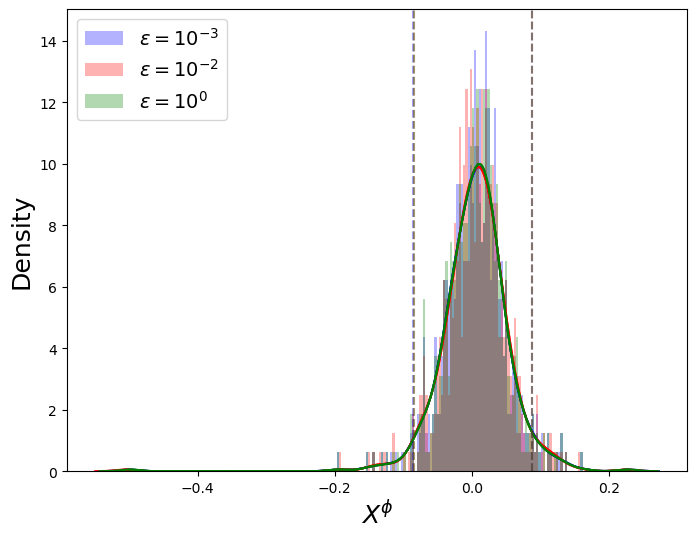

In [156]:
PlotComparison(agent.X_phi_history, agent.X_theta_history)